In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.io
import itertools as it
import scipy.special as psi
plt.style.use('classic')
import seaborn as sns
import pandas as pd
import math as mt
import time
import sys

sys.path.insert(1, '/rds/general/user/lr4617/home/4th_Year_Project/Final_Year_Project/')

from scipy.io import loadmat
from scipy import stats
from numpy.random import normal, seed
from numpy.random import rand
from scipy.integrate import quad
from scipy.io import savemat
from tempfile import TemporaryFile
from scipy.io import loadmat
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.decomposition import KernelPCA
from mpl_toolkits import mplot3d
from scipy.spatial import distance
from scipy.stats import entropy
from mPE_ultis import integrand, ubble, array_list, permutation
from util import rolling_mean, probability, probability_v2
from sklearn.cluster import KMeans

In [3]:
rats = np.load('/rds/general/user/lr4617/home/4th_Year_Project/Final_Report/control_analysis/rats_sampling_10_window_150_ordered.npy')
lengths = np.load('/rds/general/user/lr4617/home/4th_Year_Project/Final_Report/control_analysis/lengths.npy')

to_be_removed = '.ipynb_checkpoints'

root_dir = '/rds/general/user/lr4617/home/4th_Year_Project/CAPTURE_rat_multidimensional/raw_data/'
normal_trajs = os.listdir(root_dir + 'normal')
drug_trajs_1 = os.listdir(root_dir + 'caffeine')
drug_trajs_2 = os.listdir(root_dir + 'amphetamine')


if to_be_removed in normal_trajs:
    idx = normal_trajs.index(to_be_removed)
    normal_trajs.pop(idx)
    normal_trajs.sort()

    
if to_be_removed in drug_trajs_1:
    idx = drug_trajs_1drug_trajs_1.index(to_be_removed)
    drug_trajs_1.pop(idx)
    drug_trajs_1.sort()

if to_be_removed in drug_trajs_2:
    idx = drug_trajs_2.index(to_be_removed)
    drug_trajs_2.pop(idx)
    drug_trajs_2.sort()

names = normal_trajs + drug_trajs_1 + drug_trajs_2

In [14]:
###################################################################################################################################################
#################################################################### PARAMS #######################################################################
###################################################################################################################################################
n_PC = 3
significance_level = 0.01
decimals = 3
use_all = True
n_clusters_kmeans = 15
unit_length_entropy = 1500

###################################################################################################################################################
################################################################ LOAD TRAJECTORIES ################################################################
###################################################################################################################################################

print('########################## LOADING TRAJECTORIES ##########################')

modes = ['normal', 'drug']
names = []
root_dir = '/rds/general/user/lr4617/home/4th_Year_Project/CAPTURE_rat_multidimensional/raw_data/'
# load entire high-dimensional trajectories
cnt = 0
lengths = []
for mode in modes:
    trajs = os.listdir(root_dir + mode + '/' )
    for traj_n in trajs:
        names.append(traj_n)
        if traj_n != '.ipynb_checkpoints': 
            # loading entire high-dimensional trajectory
            path = root_dir + mode + '/' + traj_n + '/' + 'trajectories_na/'
            trajectories = os.listdir(path)
            # removing NaN columns
            nan_cols = []
            for i, time_bin in enumerate(trajectories):
                if time_bin != 'behavs' and time_bin != '.ipynb_checkpoints':
                    trajectory = loadmat(path + time_bin)
                    trajectory = trajectory['trajectory'] 
                    for i in range(trajectory.shape[1]):
                        if np.isnan(trajectory[:, i]).all():
                            nan_cols.append(i)

            # decide whether to use sub-sampling or not
            nan_cols = np.asarray(nan_cols)
            a = 0
            sub_sampling = 1
            window = 150

            # create trajectory
            if nan_cols.size > 0:
                if len(np.where(nan_cols==nan_cols[0])[0])*3 == len(nan_cols):
                    sampled_trajectories = np.zeros( (int((trajectory.shape[0]*len(trajectories))/sub_sampling), trajectory.shape[1]-len(nan_cols)) )
            else:
                sampled_trajectories = np.zeros( (int((trajectory.shape[0]*len(trajectories))/sub_sampling), trajectory.shape[1]) )

            for i, time_bin in enumerate(trajectories):
                if time_bin != 'behavs':
                    trajectory = loadmat(path + time_bin)
                    trajectory = trajectory['trajectory'] 
                    if nan_cols.size > 0:
                        trajectory = np.delete(trajectory, nan_cols, 1)
                    
                    mov_av_traj = rolling_mean(trajectory, window, overlapping=True)                    
                    #idxs = np.arange(0, mov_av_traj.shape[0], sub_sampling)
                    #mov_av_traj =  mov_av_traj[idxs, :]
                    
                    idx_2 = i*mov_av_traj.shape[0]
                    sampled_trajectories[idx_2:idx_2+mov_av_traj.shape[0], 0:sampled_trajectories.shape[1]] = mov_av_traj
                    
            # convert nan to number when not it is a sparse recurrence (not an entire column)
            sampled_trajectories = np.nan_to_num(sampled_trajectories)
            lengths.append(sampled_trajectories.shape[0])

            # append trajectory to all trajectories
            if cnt==0:
                rats = sampled_trajectories
            if cnt>0:
                rats = np.concatenate((rats, sampled_trajectories), axis=0)
                
            cnt += 1

            print(rats.shape) 
            
path_out = '/rds/general/user/lr4617/home/4th_Year_Project/Final_Report/control_analysis/rats_no_sampling_window_150.npy'
np.save(path_out, rats)

########################## LOADING TRAJECTORIES ##########################
(10476000, 60)
(22464000, 60)
(31212000, 60)
(39420000, 60)
(42768000, 60)
(46116000, 60)
(48060000, 60)
(51408000, 60)
(54756000, 60)
(58104000, 60)
(61452000, 60)
(64800000, 60)


In [4]:
def mPE__(*argv):    
    g=len(argv)
    
    if g==2:
        n=argv[1]
        datain=argv[0]
        lamin=np.array([1])
        epsin=np.array([1])
    if g==3:
        n=argv[1]
        datain=argv[0]
        lamin=np.array([1])
        epsin=argv[2]
    if g==4:
        n=argv[1]
        datain=argv[0]
        lamin=argv[3]
        epsin=argv[2]
    
#    Check for the data to be in the right dimension        
    if datain.shape[0] == 1 or datain.shape[1] == 1:
        if len(datain[:,0])>len(datain[0,:]):
            datain=datain.transpose()
    else:
        if len(datain[:,1])>len(datain[1,:]):
            datain=datain.transpose()
        
    scalesno=len(epsin)
    lagno=len(lamin)
    HH=np.zeros((lagno,scalesno))
    norm_HH=np.zeros((lagno,scalesno))
#    Definition of parameters: fac is the number of possible permutations
#    Elem is the No of data points
#    Dim is the dimensionality of the samples
    
    for lam in range(0,lagno):
        for eps in range(0,scalesno):
            scale=epsin[eps]
            L=lamin[lam]
            xlen=len(datain[0,:])
            ylen=np.round((xlen/scale)-0.5)
            ylen=ylen.astype(int)
            D=np.zeros((len(datain[:,0]),ylen))
            for ylenc in range(0,ylen):
                dfg=datain[:,((ylenc)*scale):((ylenc+1)*scale)]
                fhk=np.sum(dfg,axis=1)
                r=(1/scale)*fhk
                D[:,ylenc]=r
                
            data=D
            fac=mt.factorial(n)
            elem=len(data[0,:])
            dim=len(data[:,0])
            
        #    A is a n-by-factorial(n) matrix that shows all the 
        #    possible permutations of n elements
            A=permutation(n)
            
        #    counter is a factorial(n) square matrix that counts the recurrence of
        #    a dim-dimensional permutation
            lpi=fac*np.ones((dim))
            lpi=lpi.astype(int)
            nj = lpi.tolist()
            counter=np.zeros((nj))
            
        #    For each iteration i, a series of n points is sampled from the 
        #    data set and the corresponding permutation is identified. 
        #    The counter matrix keeps track of the numiber of times a certain
        #    permutation, or combination of permutations is observed. 
            for i in range(0, elem-n*L+L-1):
                coord=np.zeros((dim))
                for num in range(0,dim):
                    sample=data[num,range(i,i+L*(n),L)]
                    ord=ubble(sample)
                    perm_num=0
                    check_1=1
                    check_2=1
                    
                    while (perm_num<=fac) and (check_2):
                       
                        check_1=1
                        for j in range(0,n-1):
                            if ord[j]!=A[perm_num,j]:
                                check_1=0
                        if check_1:
                            coord[num]=perm_num
                            check_2=0
                            
                        perm_num=perm_num+1
                
                    
                coord=coord.astype(int)
                coord1=tuple(coord)
                counter[coord1]=counter[coord1]+1
                
        #    Once the counter matrix is complete, each element is divided by the
        #    total number of samples to get a empirical probability, and the PE is
        #    computed according to the method described in Schurmann
            
            H=0
            counter1=counter.flatten()
            for iter in range(0,(fac**dim)):
               
                rec=counter1[iter]
                tot=elem-n+1
                
                if rec==0:
                    H=H
                    
                else:
                    I = quad(integrand, 0, 1, args=(rec))
                    I=I[0]
                    coeff=((-1)**rec)*I
                    prob=(rec/tot)*(psi.digamma(tot)-psi.digamma(rec)-coeff)
                    H=H+mt.log2(mt.exp(prob))
                 
        #     The normalised entropy norm_H is computed as well
            norm_H=H/(mt.log2(fac**dim))
            
            HH[lam,eps]=H
            norm_HH[lam,eps]=norm_H
    return [HH,norm_HH]

In [5]:
def get_mPE_matrix_(reduced_traj, bins_number, traj_number, orders, random):
    if random:
        bins_number = 2
        mPE_vector = np.zeros((bins_number, traj_number, len(orders)))
        traj_length = int((reduced_traj.shape[0]/bins_number)/traj_number)
        print(mPE_vector.shape)

        for i in range(bins_number):
            idx = 0
            for j in range(0, traj_length*traj_number, traj_length):
                idx_1 = np.random.randint(np.max(reduced_traj.shape) - traj_length)
                traj = reduced_traj[idx_1: idx_1 + traj_length]
                [HH, _]=mPE__(traj, orders[0])
                mPE_vector[i, idx, 0] = HH
                idx +=1

    else:
        mPE_vector = np.zeros((bins_number, traj_number, len(orders)))
        traj_length = int((reduced_traj.shape[0]/bins_number)/traj_number)
        
        for a, order in enumerate(orders):
            
            for i in range(bins_number):
                idx = 0
                
                for j in range(0, traj_length*traj_number, traj_length):
                    idx_1 = i*traj_number*traj_length 
                    traj = reduced_traj[idx_1 + j: idx_1 + j + traj_length]
                        
                    if traj.shape[0]>0:
                        [HH, _]=mPE__(traj, order)
                        mPE_vector[i, idx, a] = HH
                        
                    idx +=1
    
    
    return mPE_vector

traj_1
TRAJECTORY  0
########################## APPLY PCA ##########################


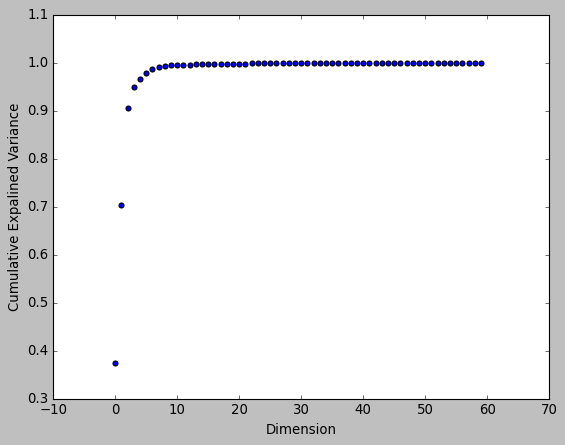

########################## CONTROL ANALYSIS ##########################
15
(2, 15, 1)


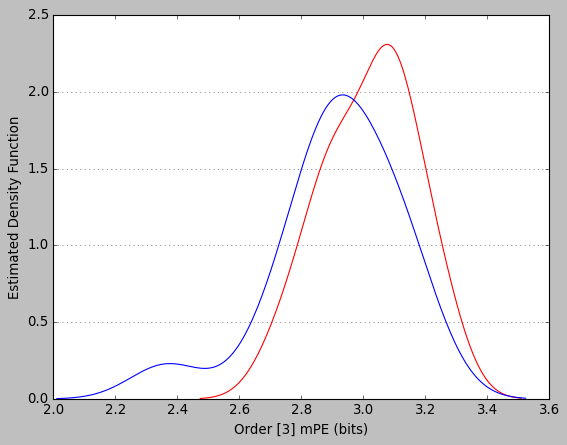

(2, 15, 1)


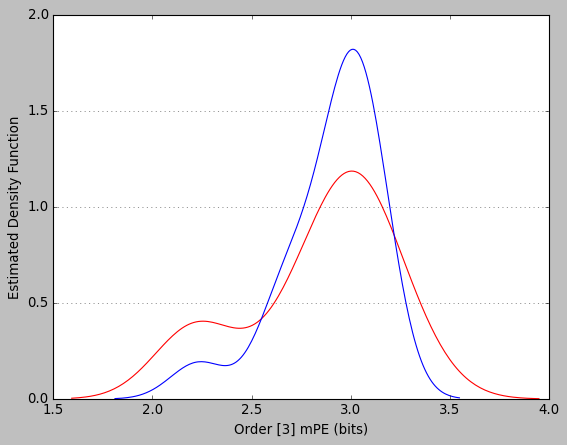

########################## ENTROPY ANALYSIS ##########################
15 15


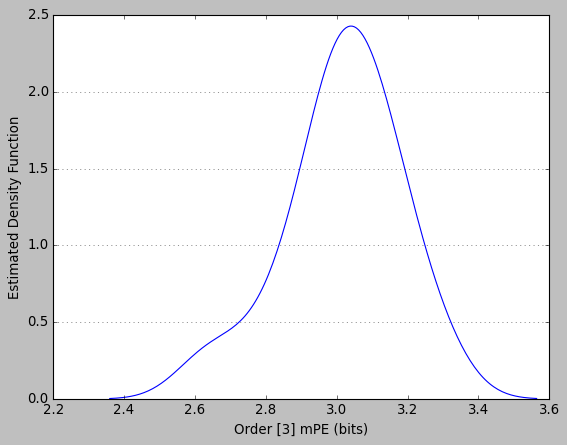

traj_2
TRAJECTORY  1
########################## APPLY PCA ##########################


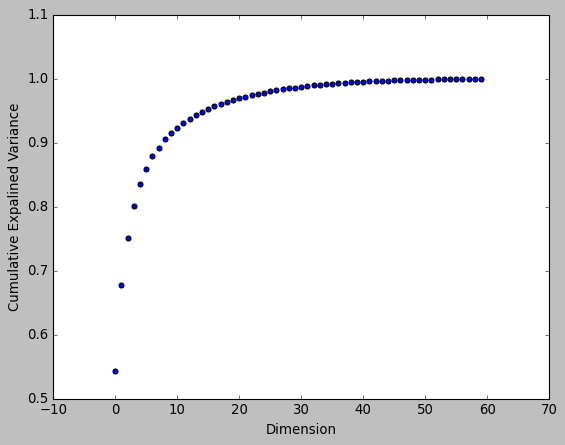

########################## CONTROL ANALYSIS ##########################
15
(2, 15, 1)


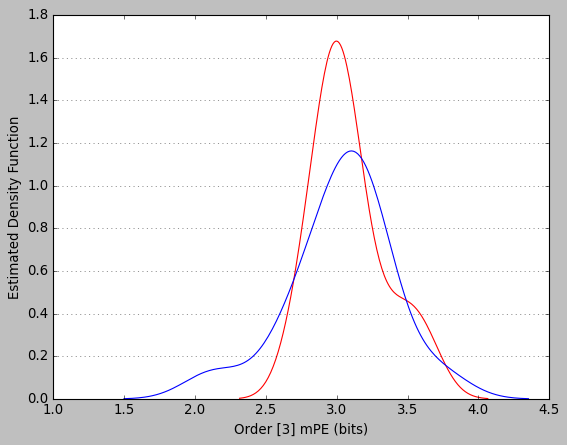

########################## ENTROPY ANALYSIS ##########################
16 15


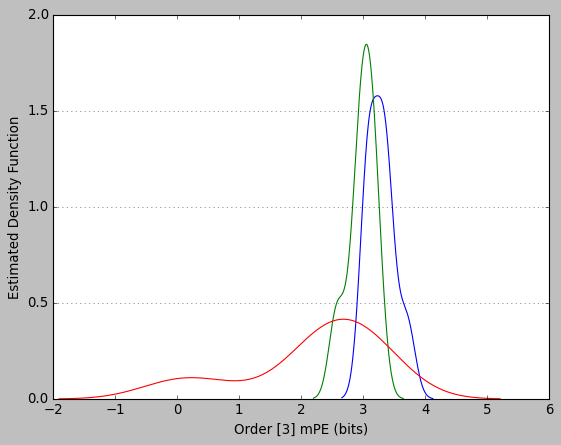

traj_3
TRAJECTORY  2
########################## APPLY PCA ##########################


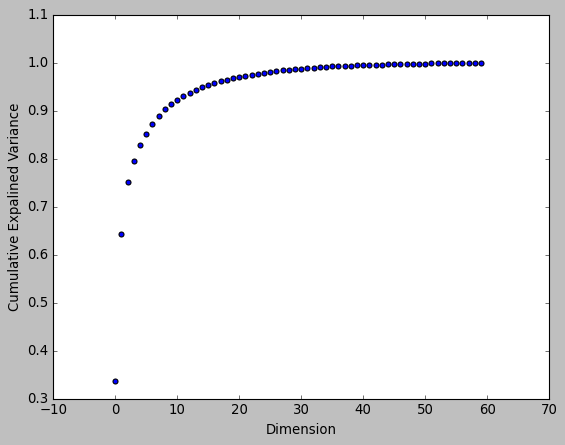

########################## CONTROL ANALYSIS ##########################
15
(2, 15, 1)


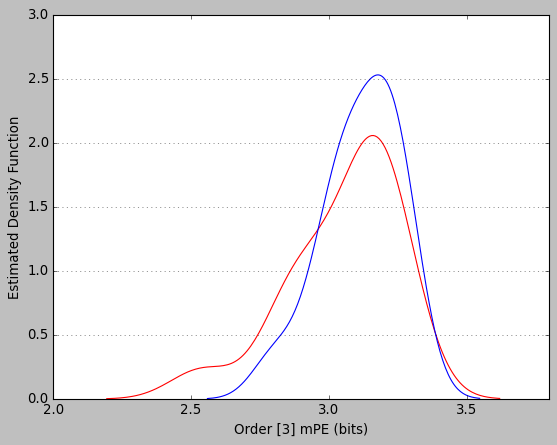

########################## ENTROPY ANALYSIS ##########################
22 15


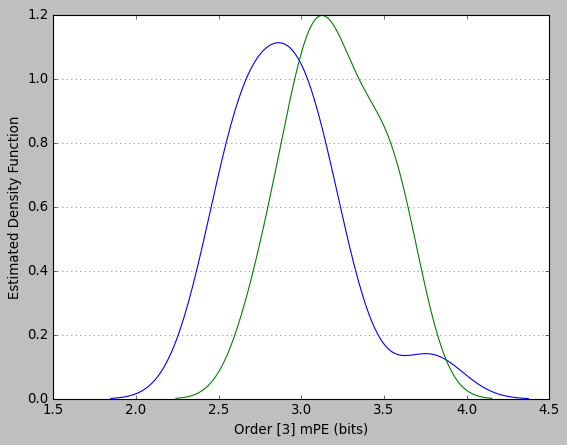

traj_5
TRAJECTORY  3
########################## APPLY PCA ##########################


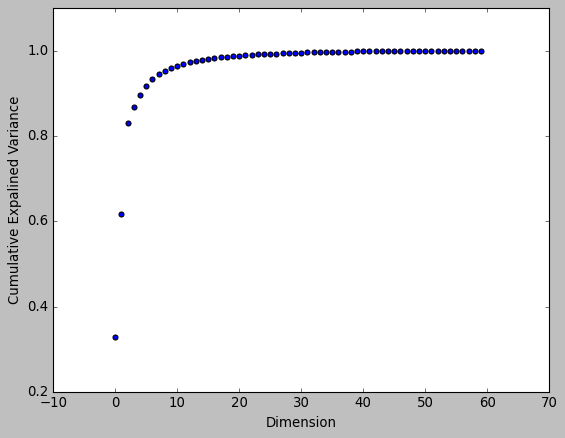

########################## CONTROL ANALYSIS ##########################
15
(2, 15, 1)


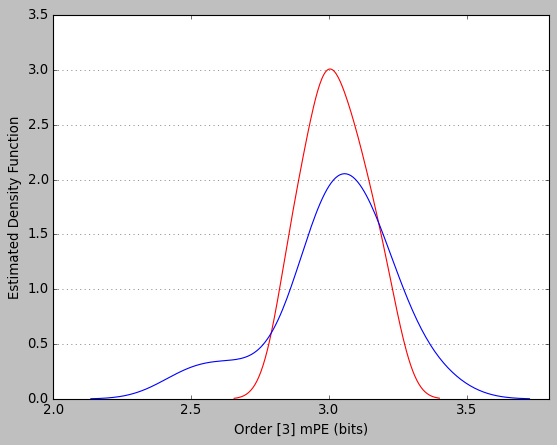

########################## ENTROPY ANALYSIS ##########################
19 15


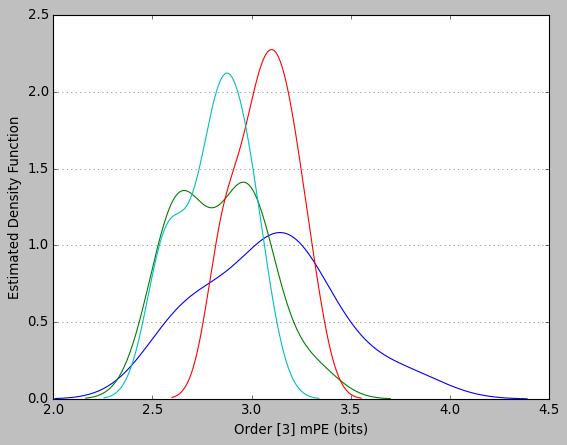

traj_8
TRAJECTORY  4
########################## APPLY PCA ##########################


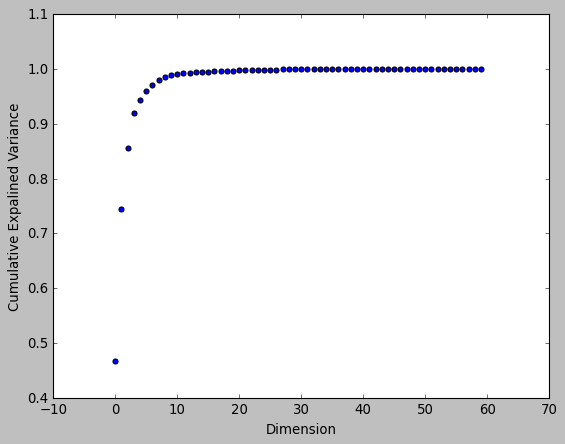

########################## CONTROL ANALYSIS ##########################
15
(2, 15, 1)


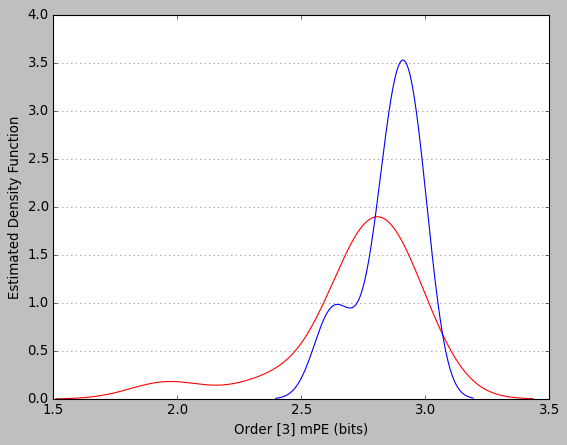

(2, 15, 1)


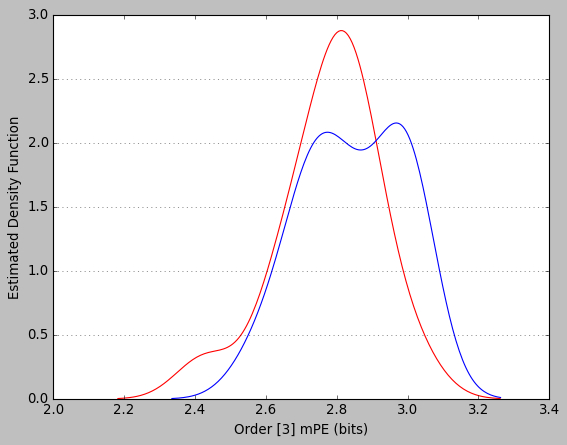

(2, 15, 1)


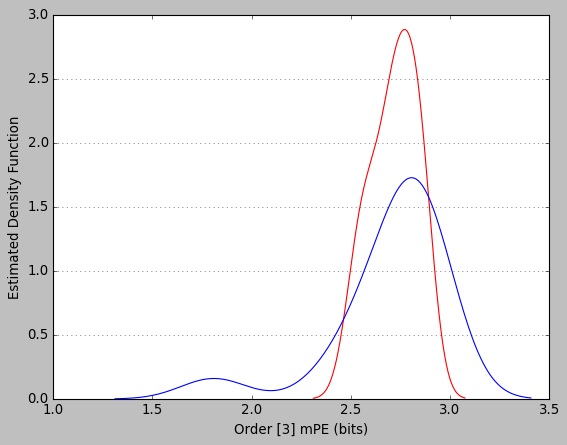

(2, 15, 1)


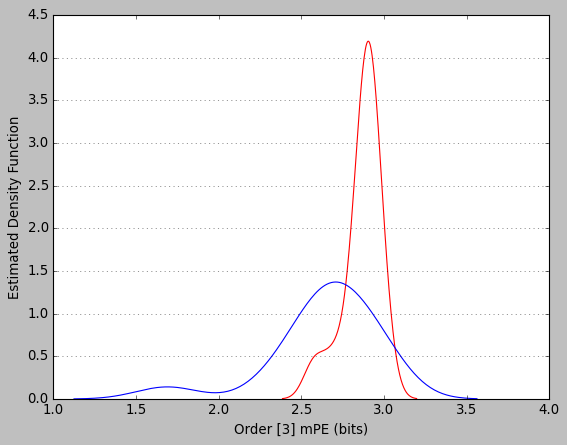

(2, 15, 1)


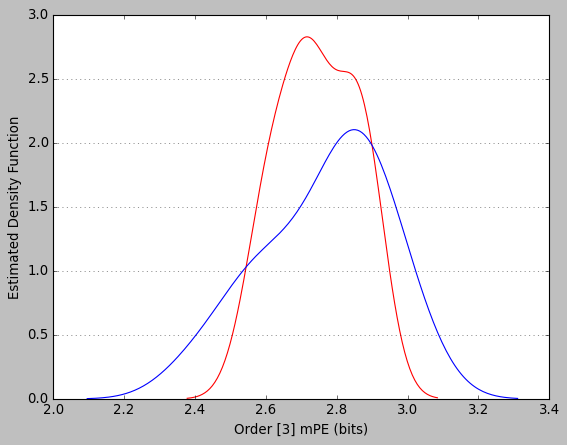

########################## ENTROPY ANALYSIS ##########################
6 15


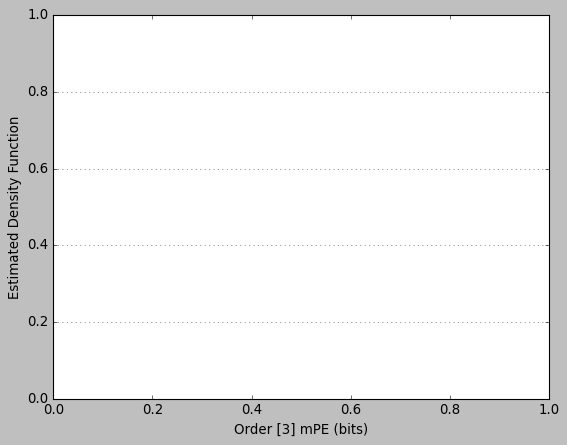

traj_4
TRAJECTORY  5
########################## APPLY PCA ##########################


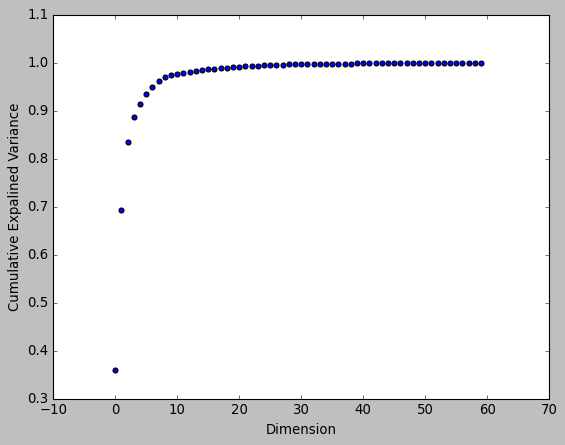

########################## CONTROL ANALYSIS ##########################
15
(2, 15, 1)


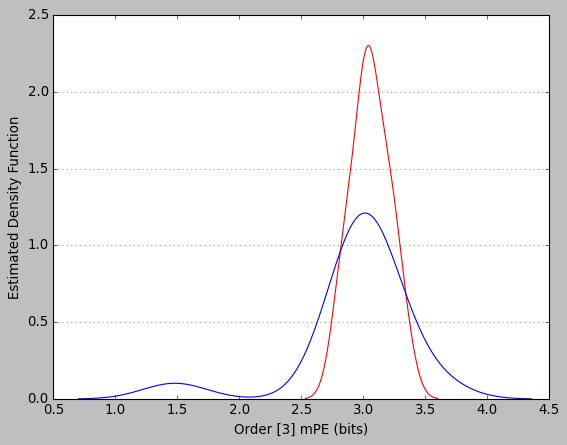

########################## ENTROPY ANALYSIS ##########################
6 15


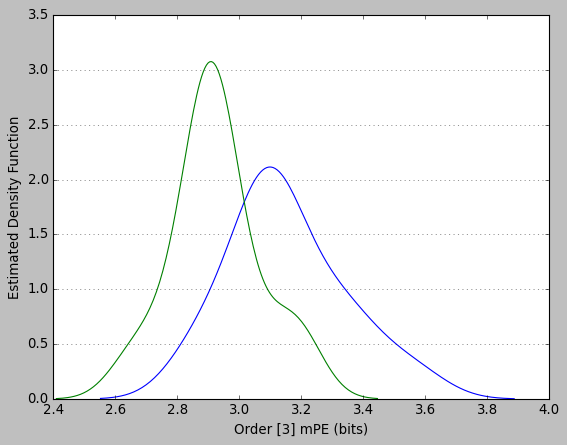

traj_2
TRAJECTORY  6
########################## APPLY PCA ##########################


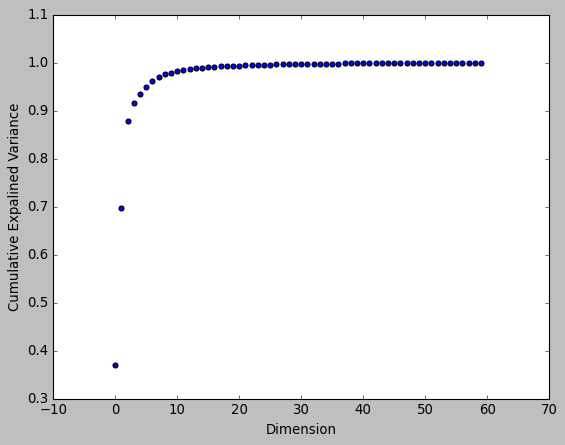

########################## CONTROL ANALYSIS ##########################
15
(2, 15, 1)


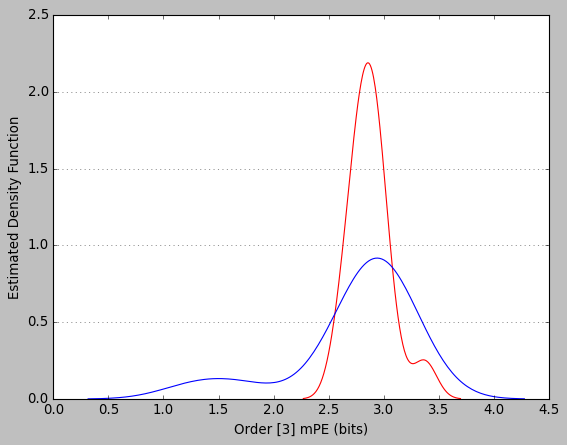

########################## ENTROPY ANALYSIS ##########################
6 15


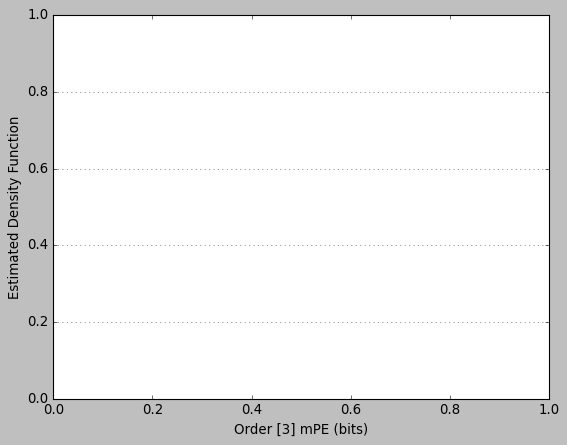

traj_6
TRAJECTORY  7
########################## APPLY PCA ##########################


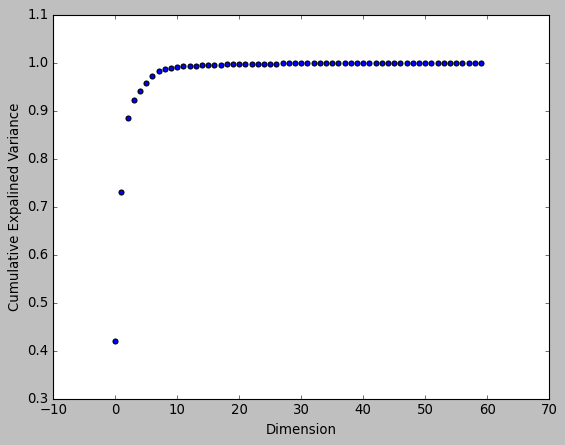

########################## CONTROL ANALYSIS ##########################
15
(2, 15, 1)


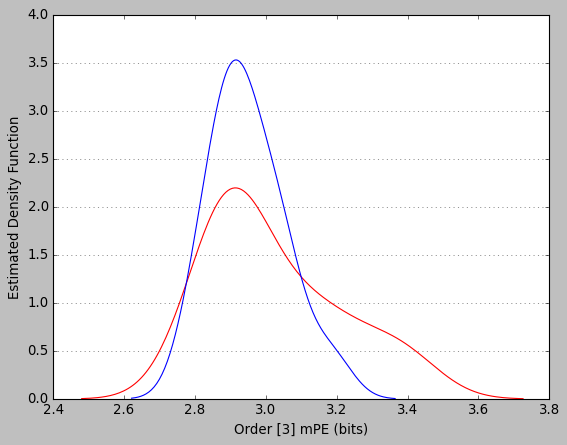

########################## ENTROPY ANALYSIS ##########################
6 15


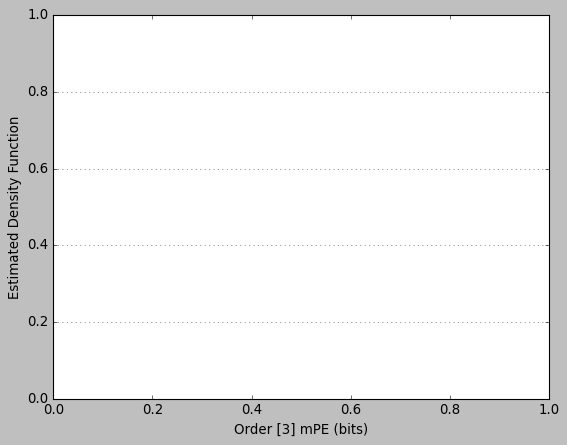

traj_5
TRAJECTORY  8
########################## APPLY PCA ##########################


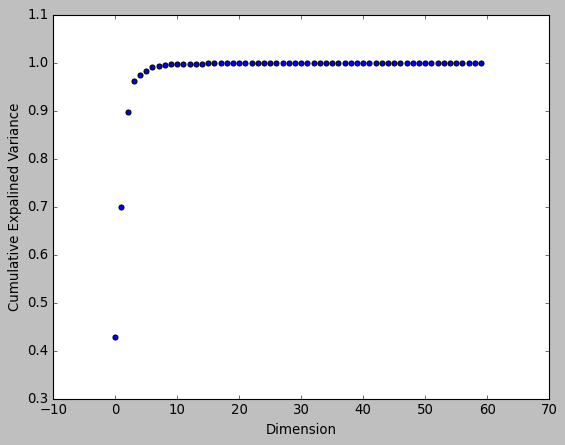

########################## CONTROL ANALYSIS ##########################
15
(2, 15, 1)


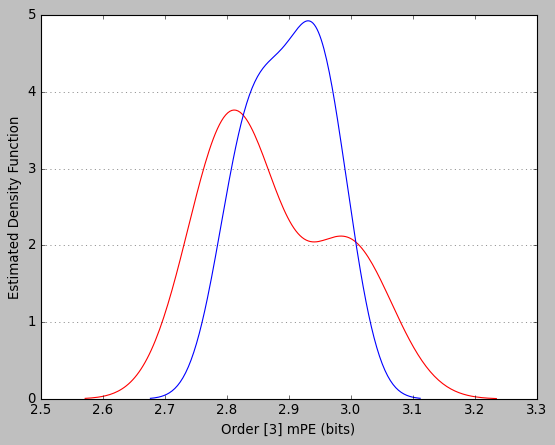

(2, 15, 1)


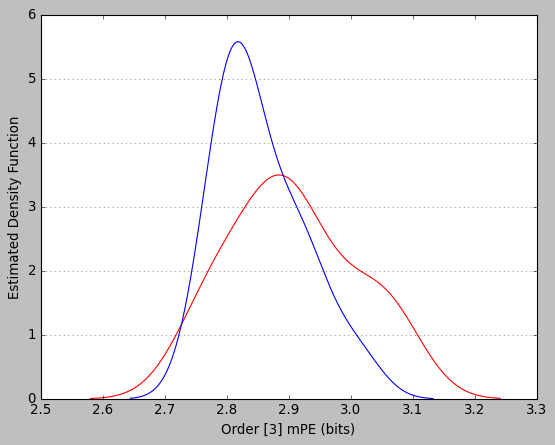

(2, 15, 1)


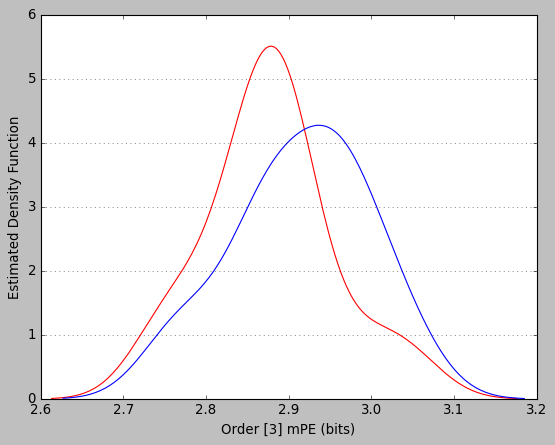

(2, 15, 1)


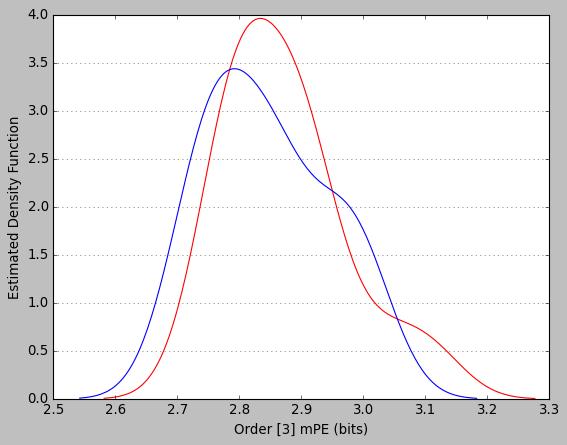

########################## ENTROPY ANALYSIS ##########################
6 15


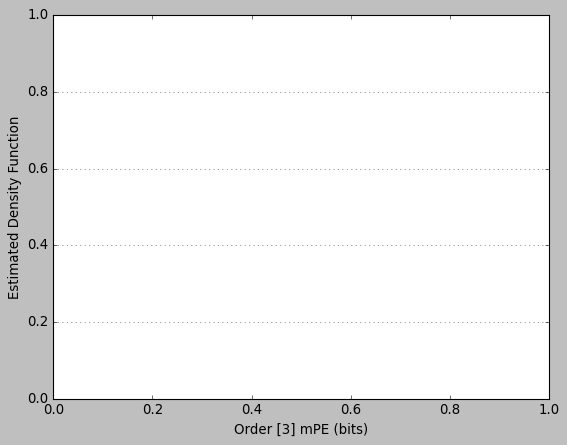

traj_3
TRAJECTORY  9
########################## APPLY PCA ##########################


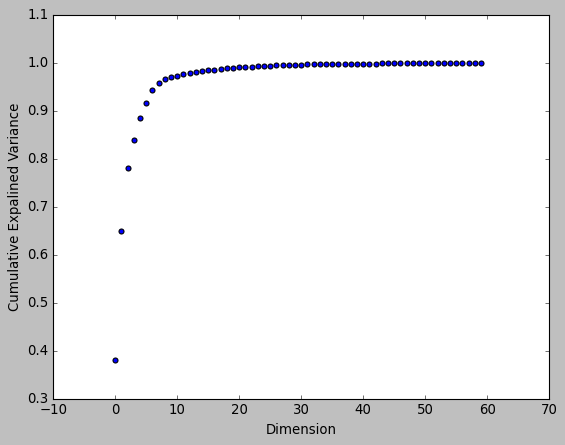

########################## CONTROL ANALYSIS ##########################
15
(2, 15, 1)


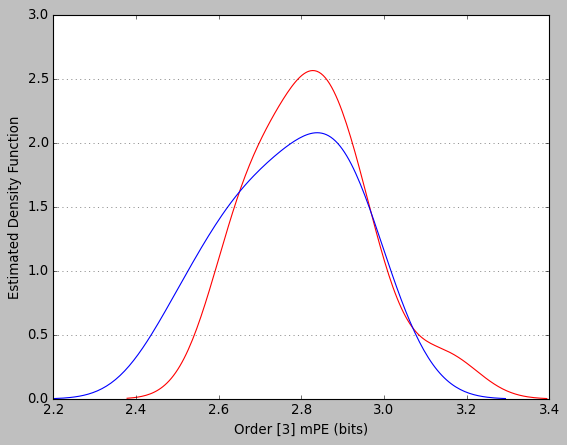

########################## ENTROPY ANALYSIS ##########################
3 15


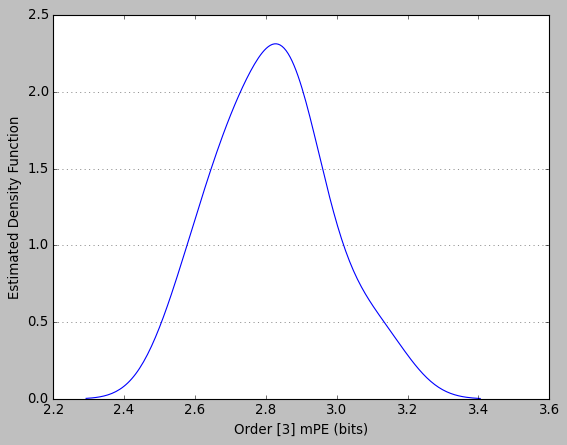

traj_7
TRAJECTORY  10
########################## APPLY PCA ##########################


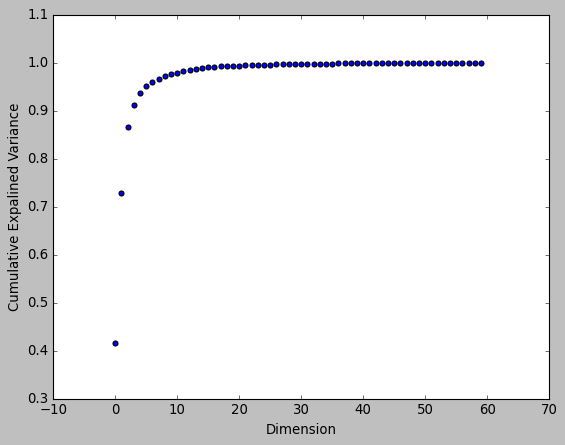

########################## CONTROL ANALYSIS ##########################
15
(2, 15, 1)


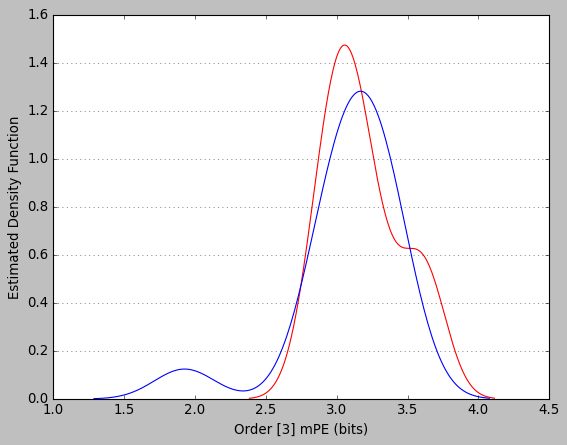

########################## ENTROPY ANALYSIS ##########################
6 15


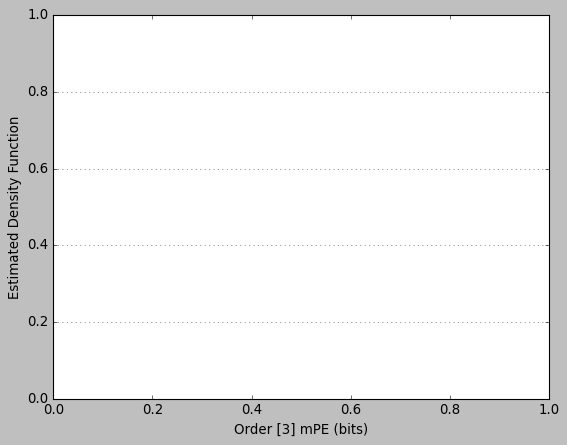

traj_1
TRAJECTORY  11
########################## APPLY PCA ##########################


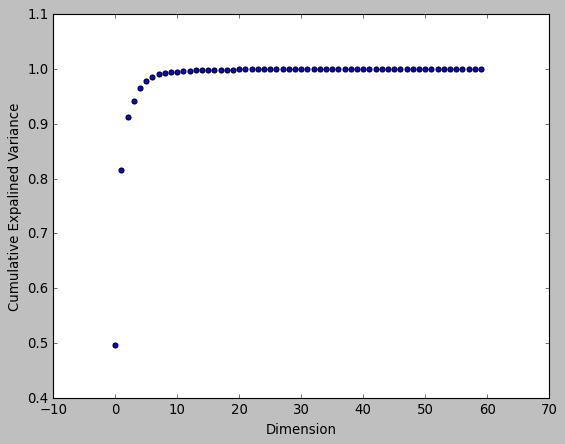

########################## CONTROL ANALYSIS ##########################
15
(2, 15, 1)


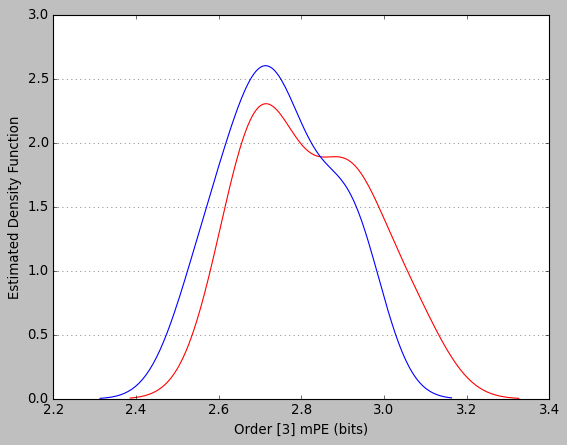

########################## ENTROPY ANALYSIS ##########################
6 15


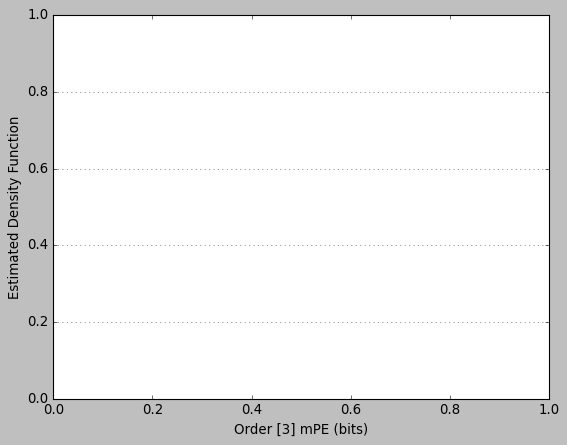

traj_1
TRAJECTORY  0
########################## APPLY PCA ##########################


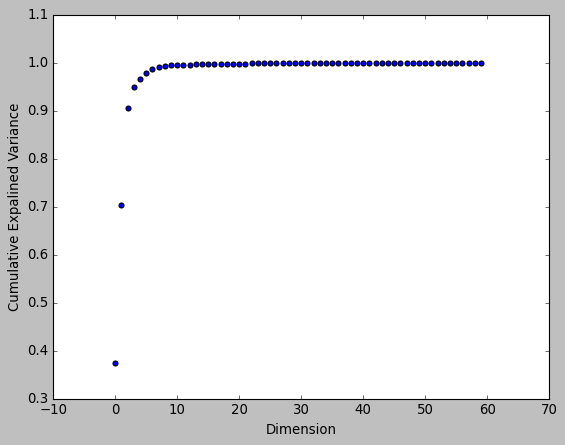

########################## CONTROL ANALYSIS ##########################
15
(2, 15, 1)


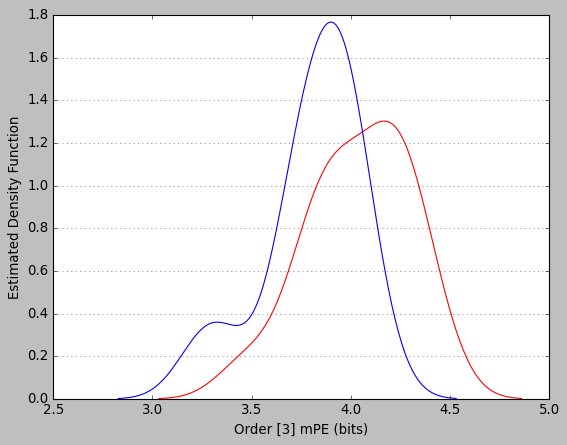

(2, 15, 1)


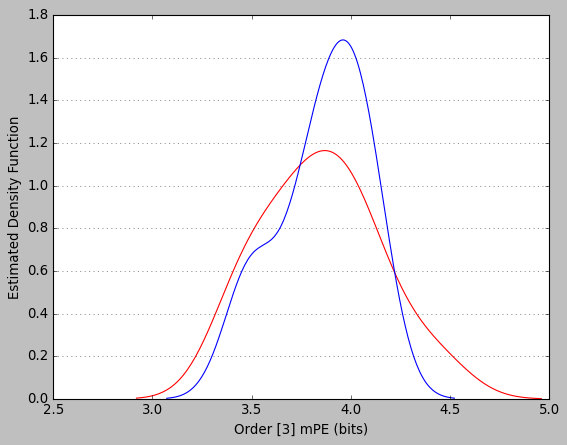

########################## ENTROPY ANALYSIS ##########################
15 15


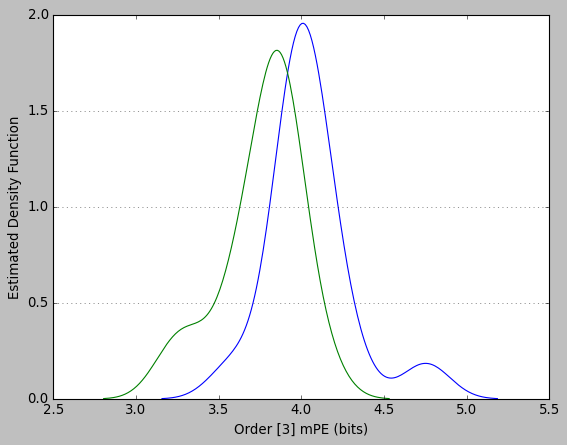

traj_2
TRAJECTORY  1
########################## APPLY PCA ##########################


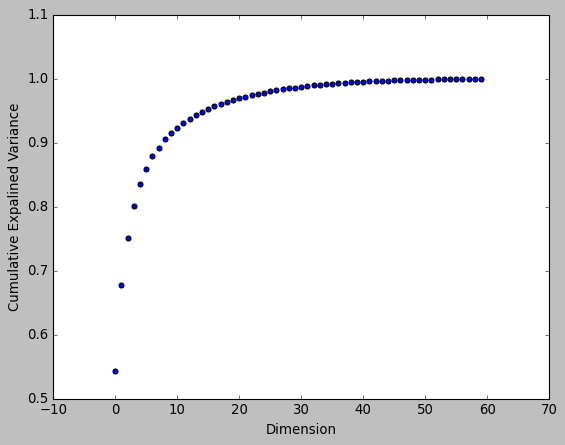

########################## CONTROL ANALYSIS ##########################
15
(2, 15, 1)


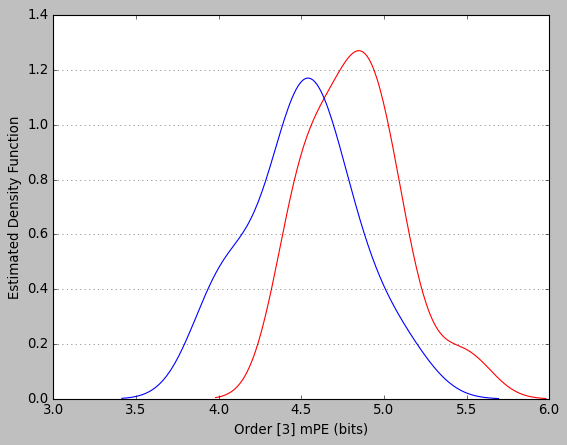

(2, 15, 1)


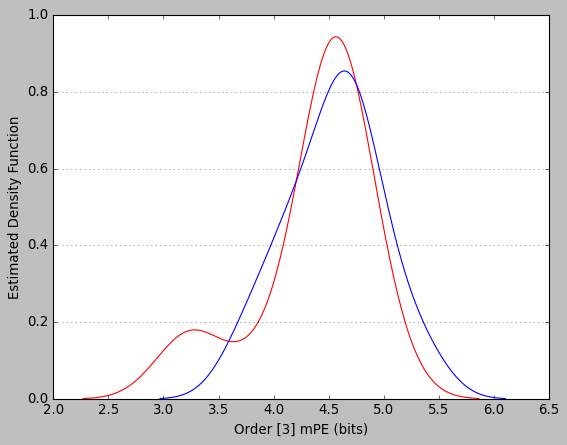

(2, 15, 1)


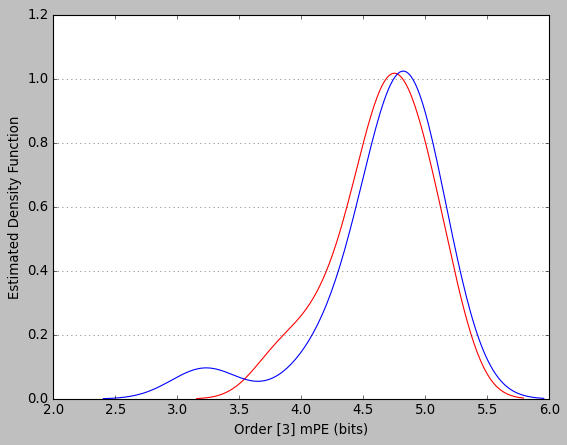

########################## ENTROPY ANALYSIS ##########################
16 15


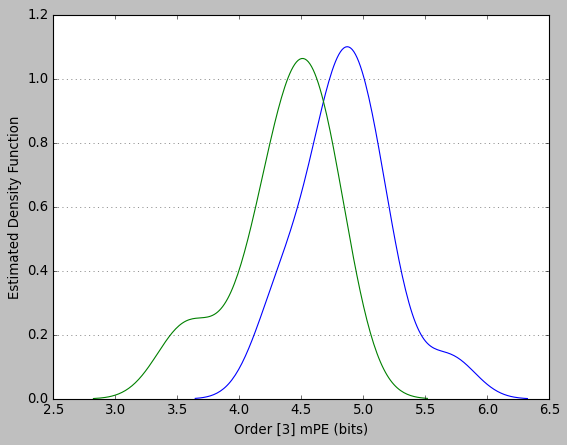

traj_3
TRAJECTORY  2
########################## APPLY PCA ##########################


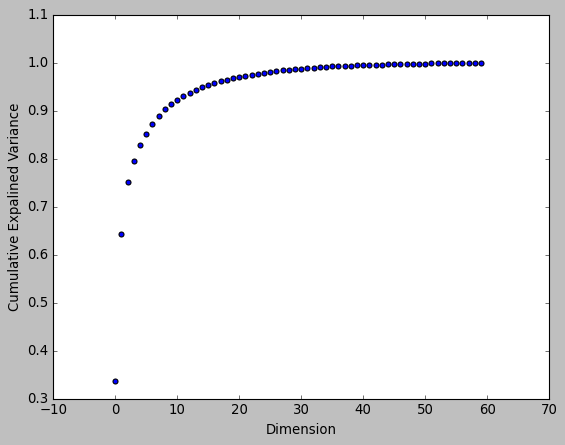

########################## CONTROL ANALYSIS ##########################
15
(2, 15, 1)


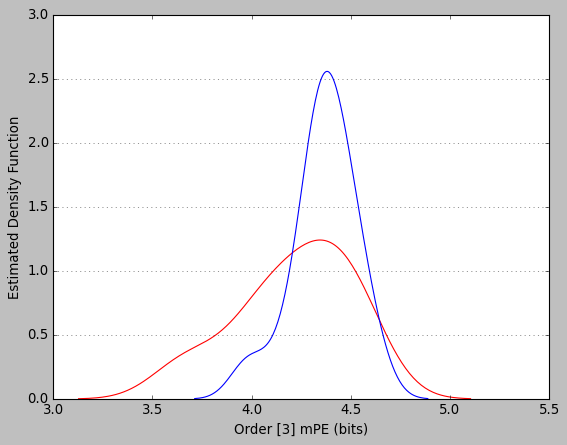

(2, 15, 1)


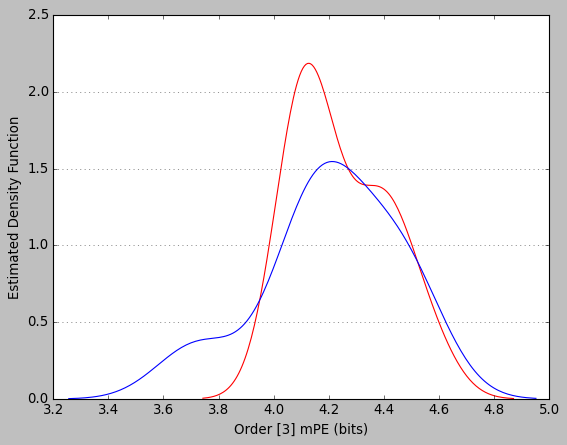

########################## ENTROPY ANALYSIS ##########################
22 15


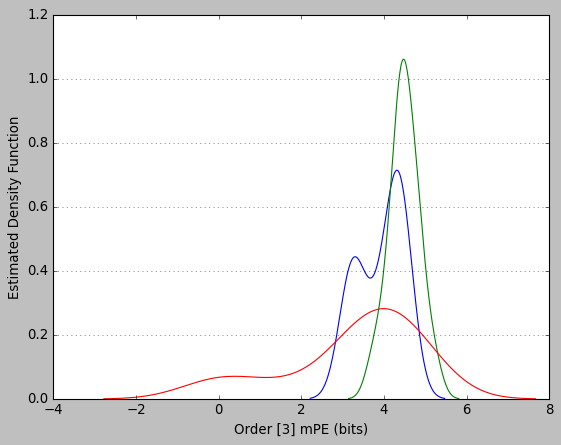

traj_5
TRAJECTORY  3
########################## APPLY PCA ##########################


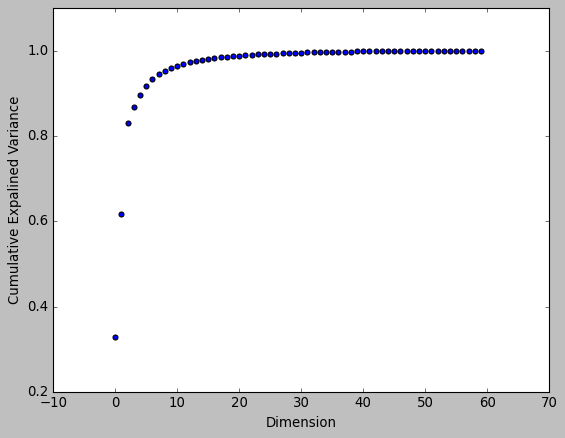

########################## CONTROL ANALYSIS ##########################
15
(2, 15, 1)


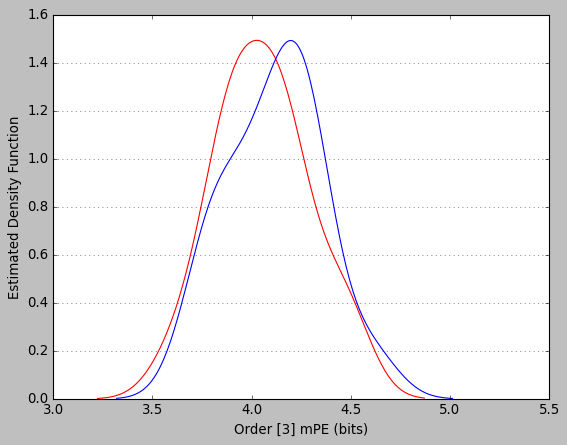

########################## ENTROPY ANALYSIS ##########################
19 15


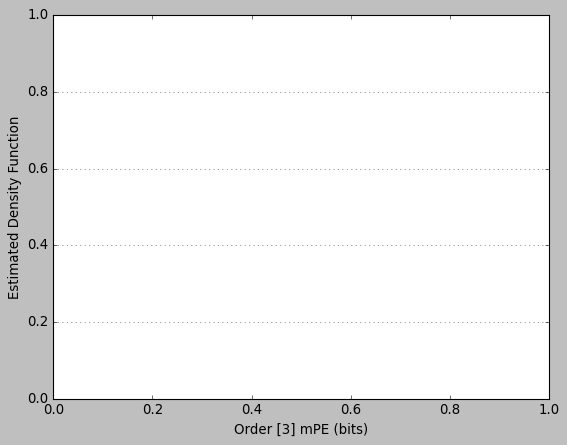

traj_8
TRAJECTORY  4
########################## APPLY PCA ##########################


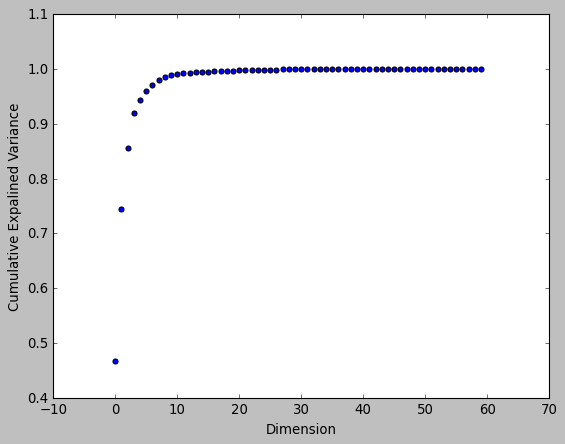

########################## CONTROL ANALYSIS ##########################
15
(2, 15, 1)


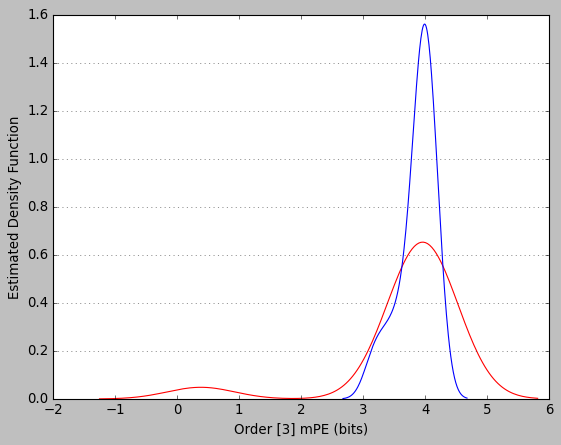

########################## ENTROPY ANALYSIS ##########################
6 15


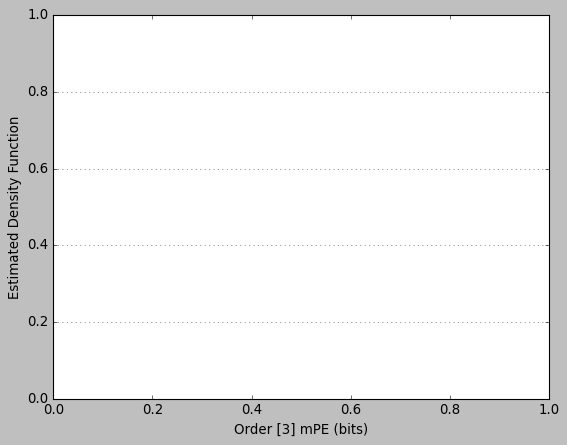

traj_4
TRAJECTORY  5
########################## APPLY PCA ##########################


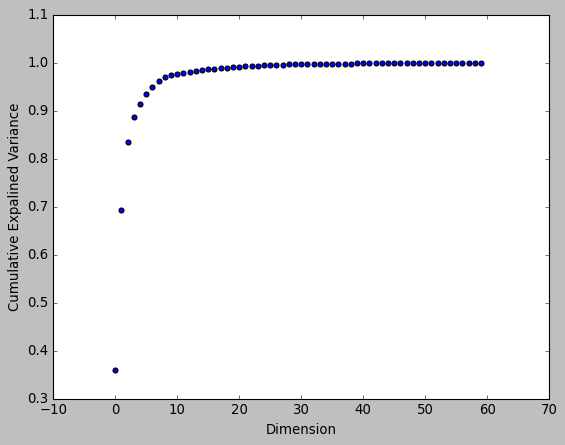

########################## CONTROL ANALYSIS ##########################
15
(2, 15, 1)


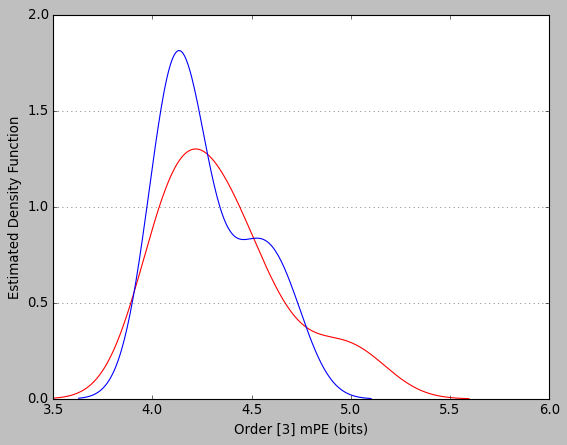

########################## ENTROPY ANALYSIS ##########################
6 15


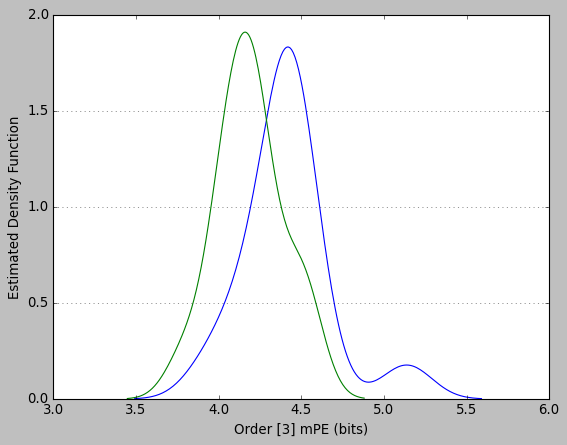

traj_2
TRAJECTORY  6
########################## APPLY PCA ##########################


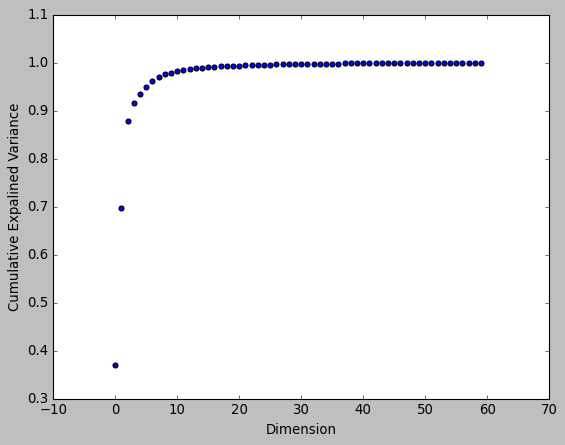

########################## CONTROL ANALYSIS ##########################
15
(2, 15, 1)


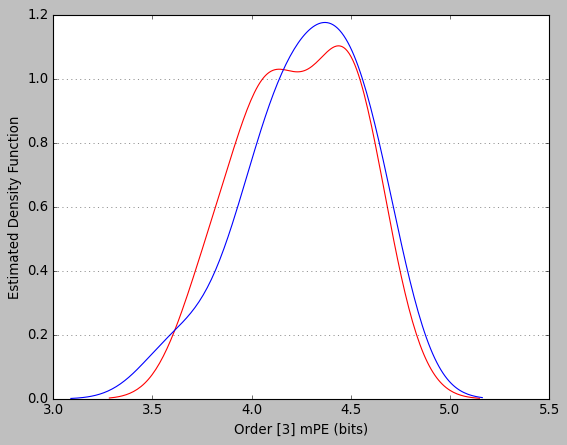

########################## ENTROPY ANALYSIS ##########################
6 15


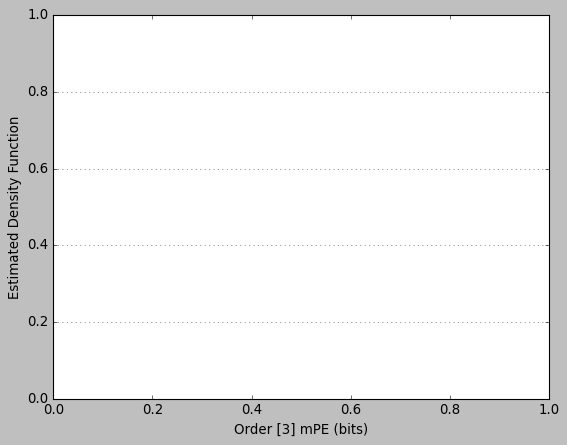

traj_6
TRAJECTORY  7
########################## APPLY PCA ##########################


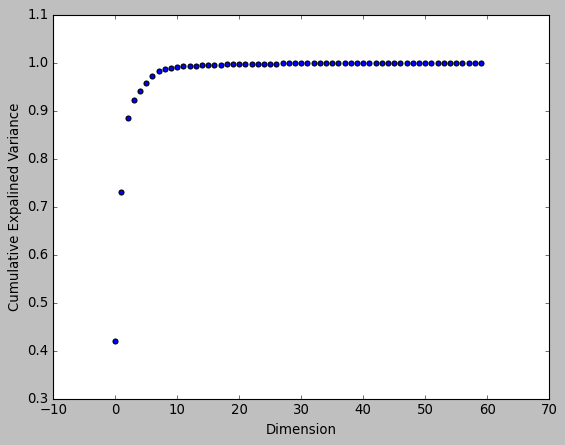

########################## CONTROL ANALYSIS ##########################
15
(2, 15, 1)


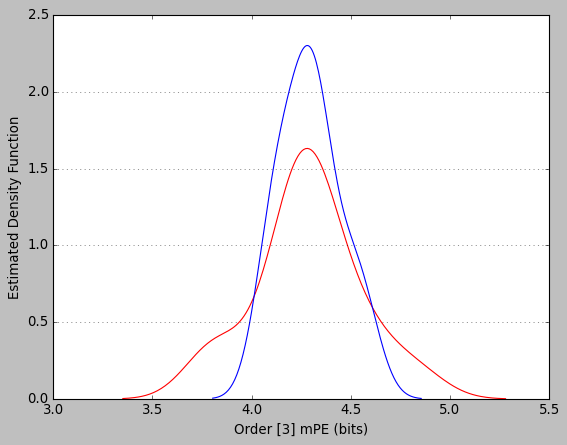

########################## ENTROPY ANALYSIS ##########################
6 15


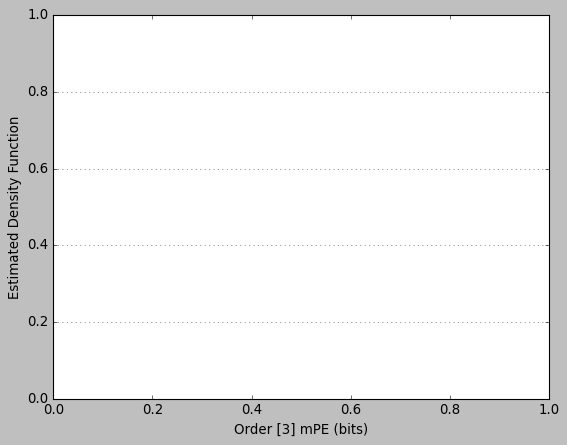

traj_5
TRAJECTORY  8
########################## APPLY PCA ##########################


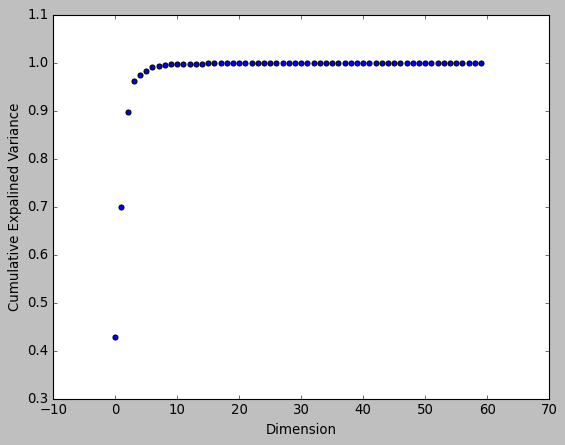

########################## CONTROL ANALYSIS ##########################
15
(2, 15, 1)


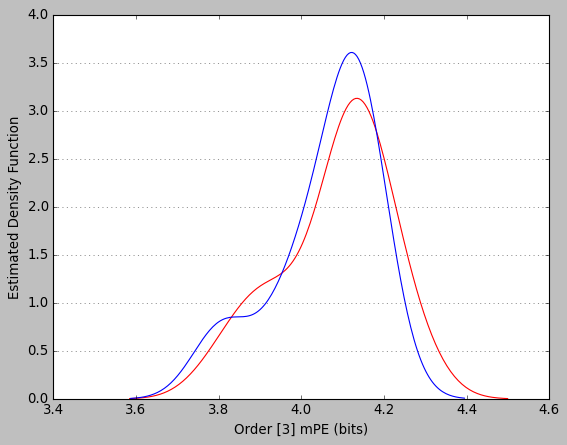

########################## ENTROPY ANALYSIS ##########################
6 15


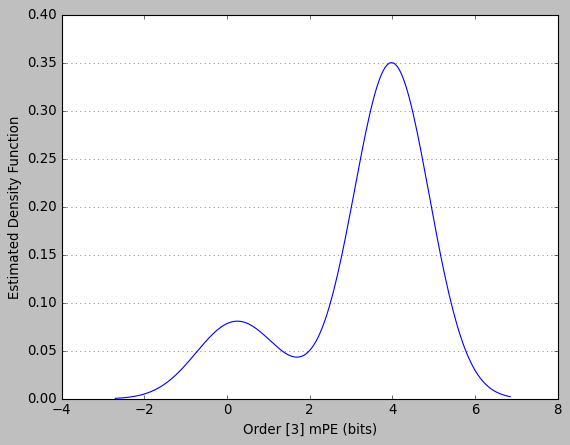

traj_3
TRAJECTORY  9
########################## APPLY PCA ##########################


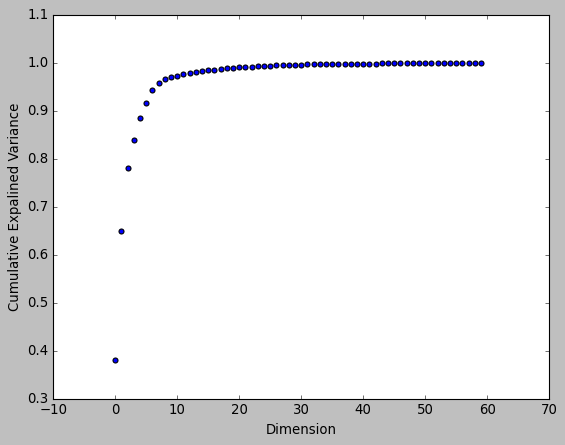

########################## CONTROL ANALYSIS ##########################
15
(2, 15, 1)


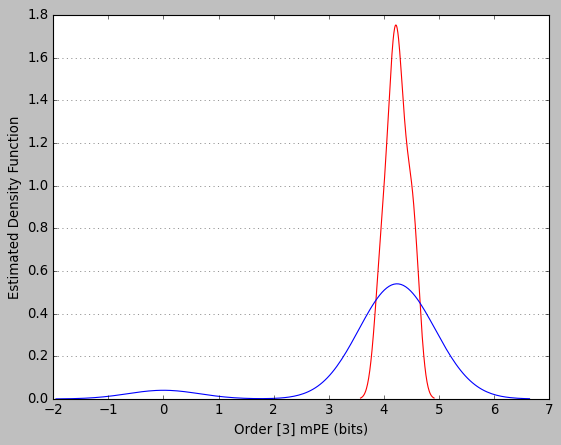

########################## ENTROPY ANALYSIS ##########################
3 15


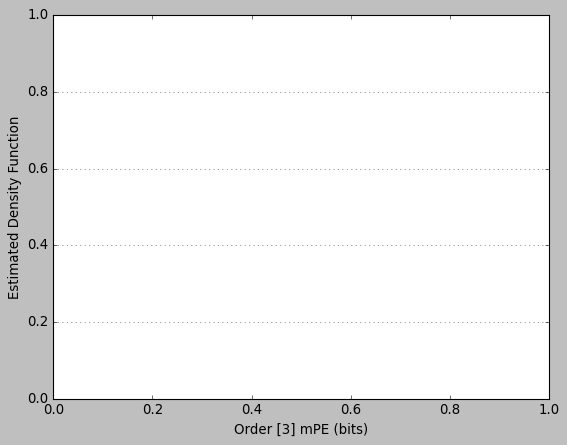

traj_7
TRAJECTORY  10
########################## APPLY PCA ##########################


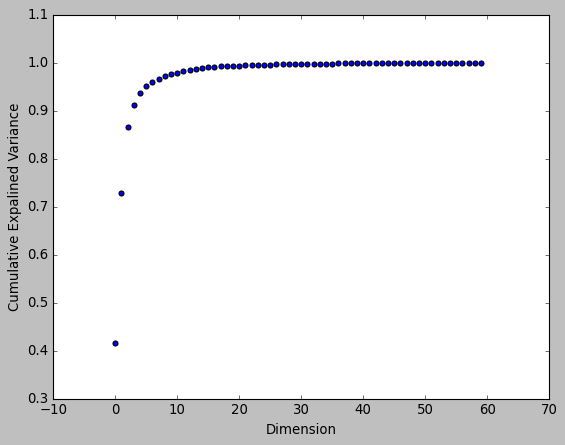

########################## CONTROL ANALYSIS ##########################
15
(2, 15, 1)


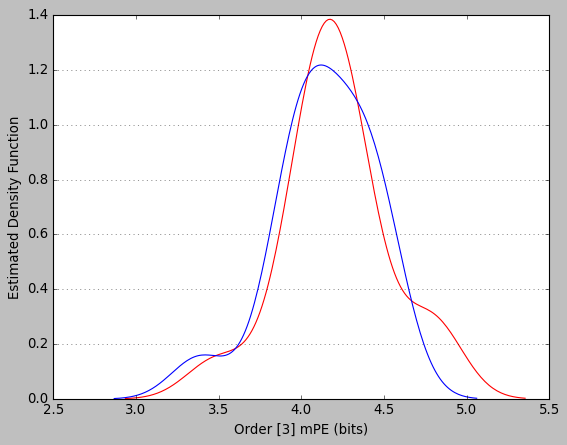

########################## ENTROPY ANALYSIS ##########################
6 15


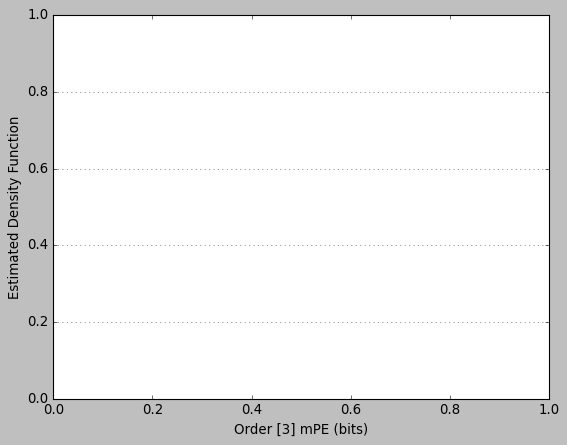

traj_1
TRAJECTORY  11
########################## APPLY PCA ##########################


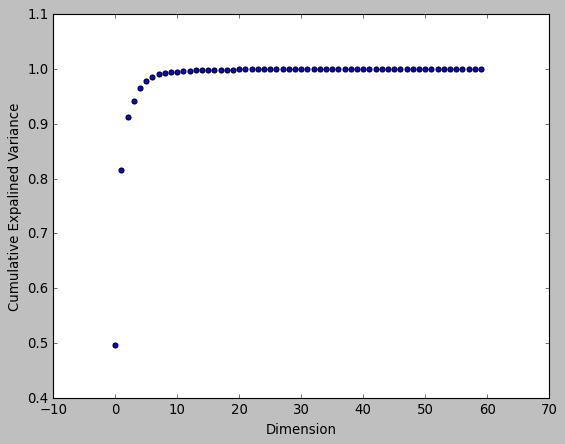

########################## CONTROL ANALYSIS ##########################
15
(2, 15, 1)


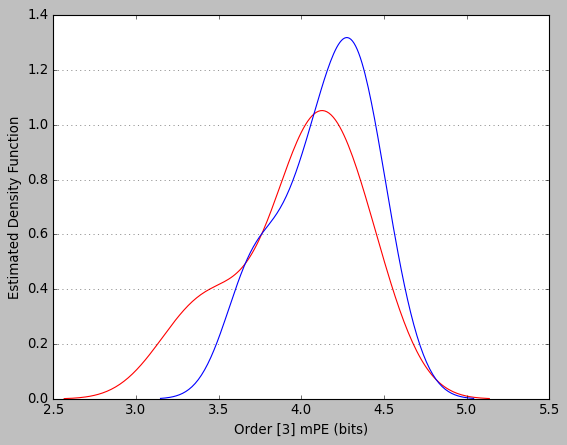

########################## ENTROPY ANALYSIS ##########################
6 15


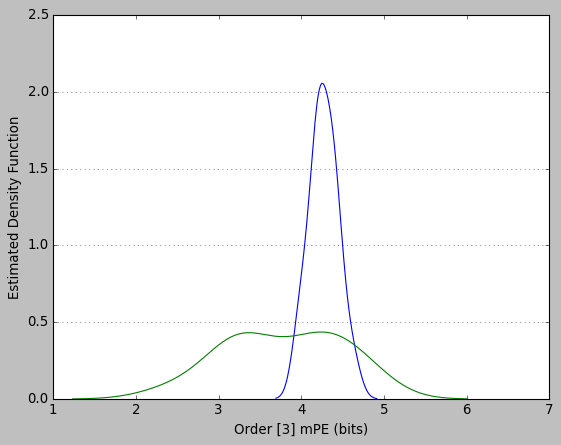

traj_1
TRAJECTORY  0
########################## APPLY PCA ##########################


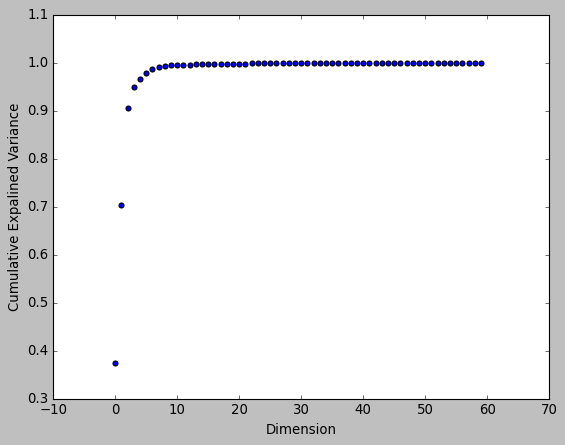

########################## CONTROL ANALYSIS ##########################
15
(2, 15, 1)


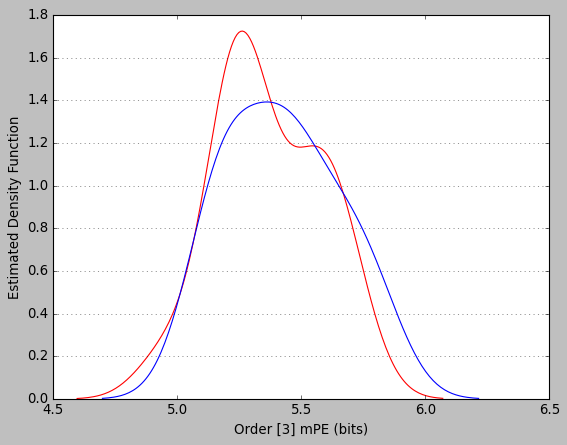

########################## ENTROPY ANALYSIS ##########################
15 15


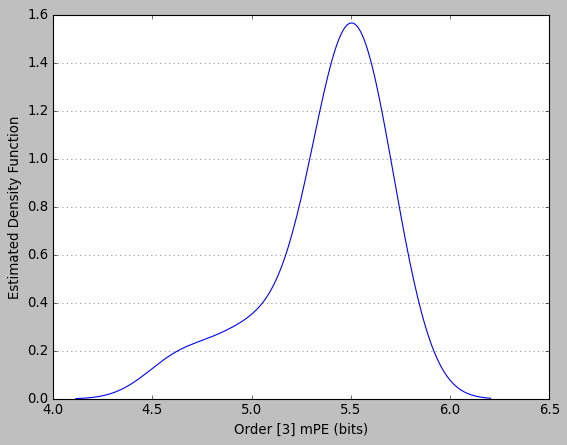

traj_2
TRAJECTORY  1
########################## APPLY PCA ##########################


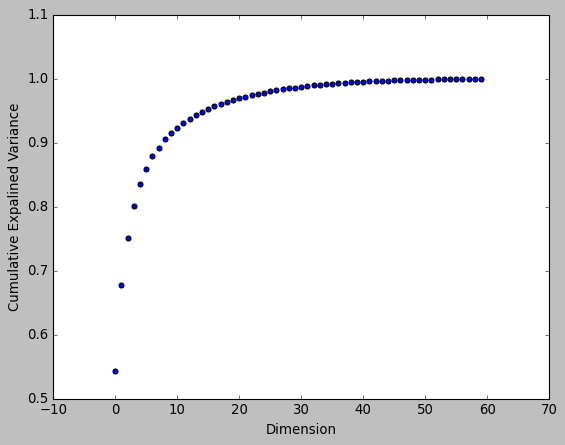

########################## CONTROL ANALYSIS ##########################
15
(2, 15, 1)


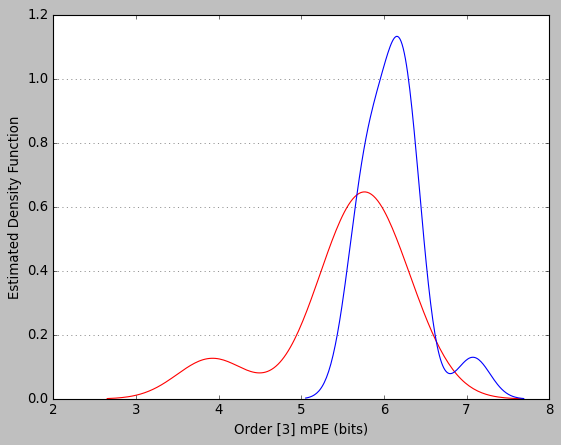

(2, 15, 1)


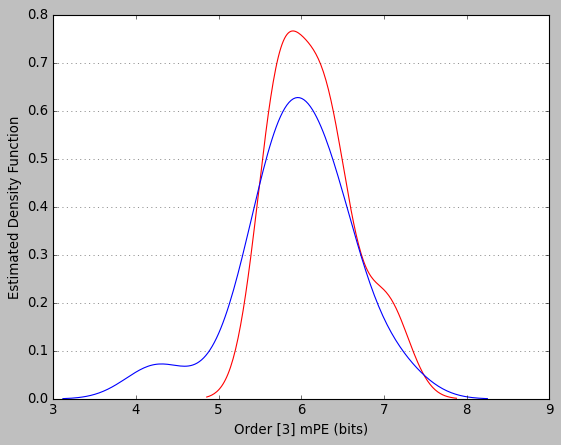

########################## ENTROPY ANALYSIS ##########################
16 15


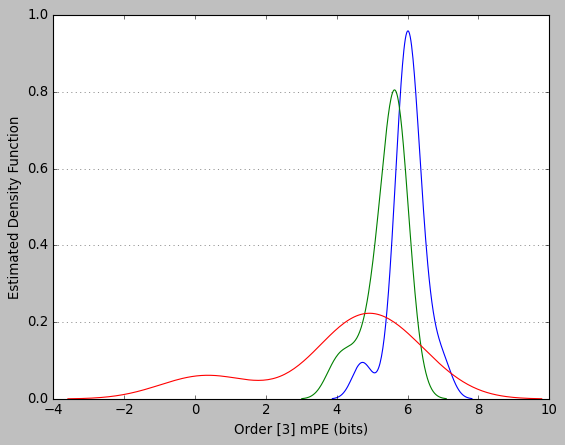

traj_3
TRAJECTORY  2
########################## APPLY PCA ##########################


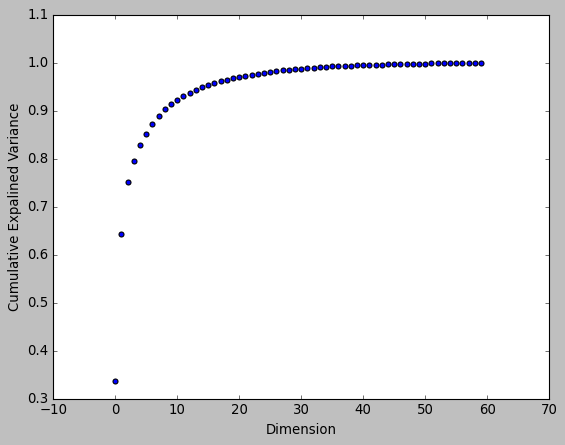

########################## CONTROL ANALYSIS ##########################
15
(2, 15, 1)


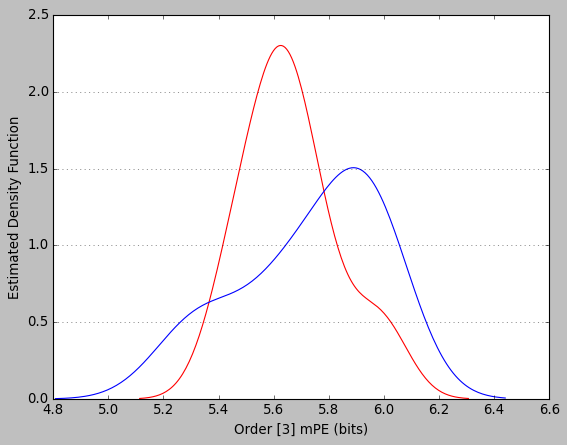

(2, 15, 1)


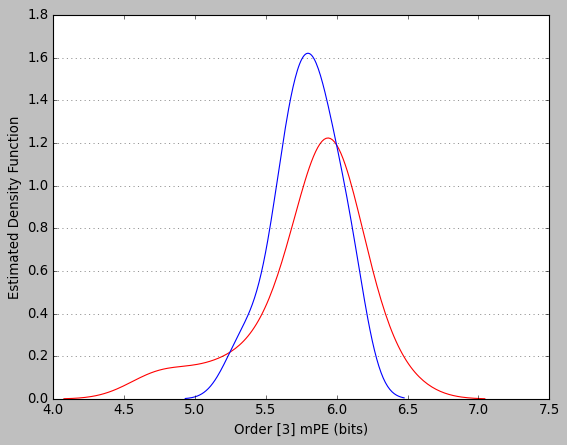

(2, 15, 1)


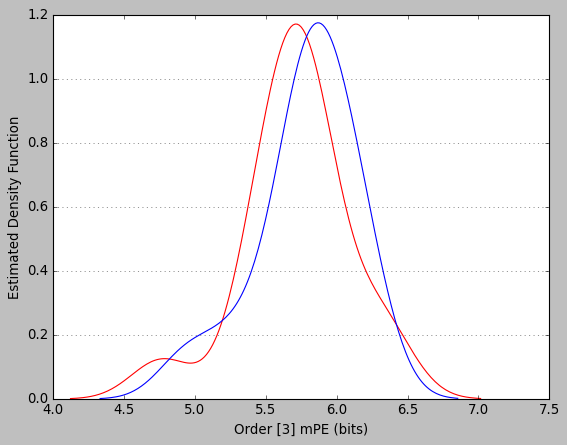

(2, 15, 1)


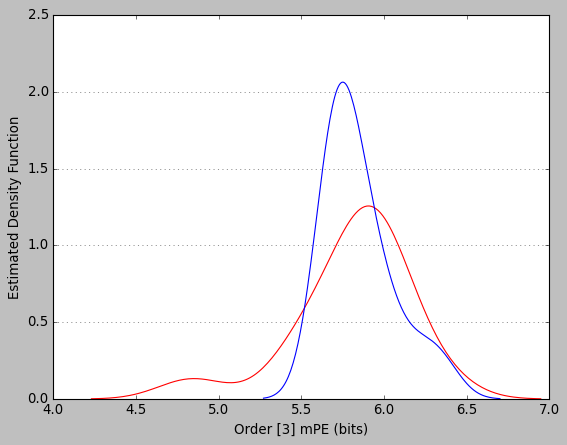

########################## ENTROPY ANALYSIS ##########################
22 15


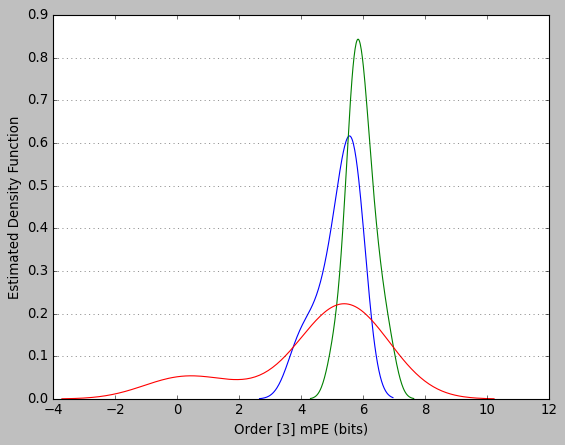

traj_5
TRAJECTORY  3
########################## APPLY PCA ##########################


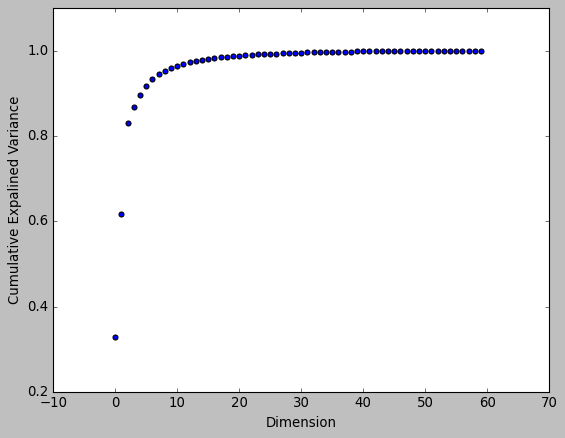

########################## CONTROL ANALYSIS ##########################
15
(2, 15, 1)


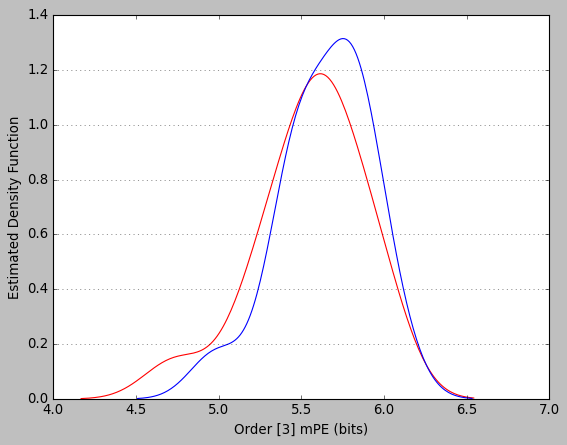

(2, 15, 1)


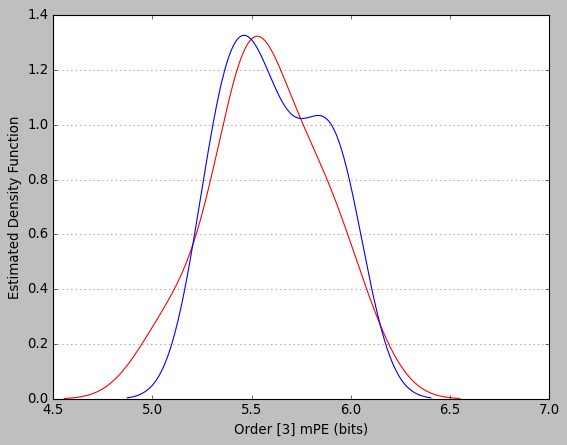

########################## ENTROPY ANALYSIS ##########################
19 15


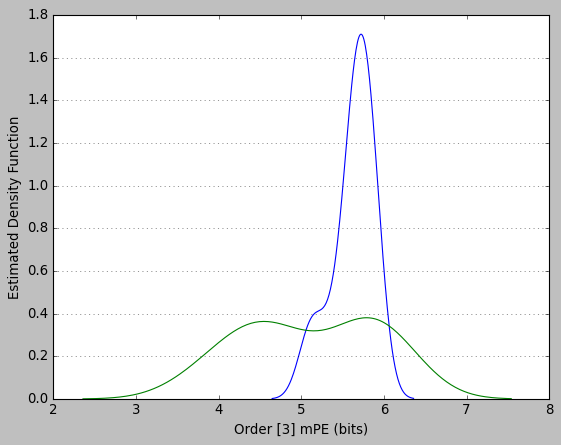

traj_8
TRAJECTORY  4
########################## APPLY PCA ##########################


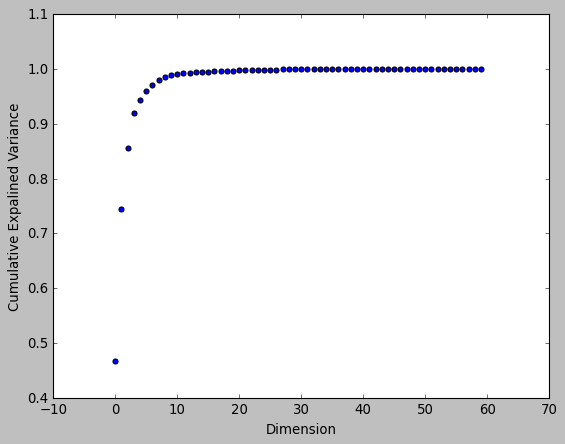

########################## CONTROL ANALYSIS ##########################
15
(2, 15, 1)


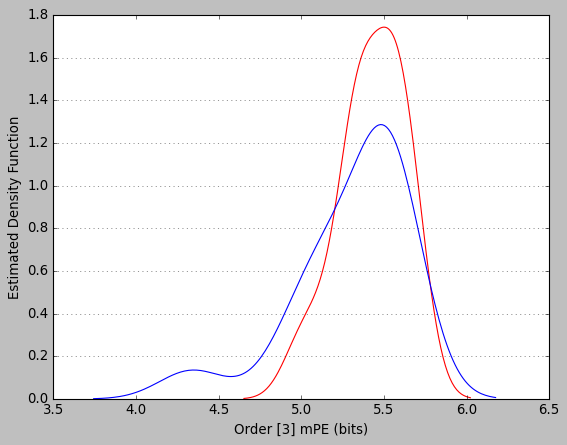

########################## ENTROPY ANALYSIS ##########################
6 15


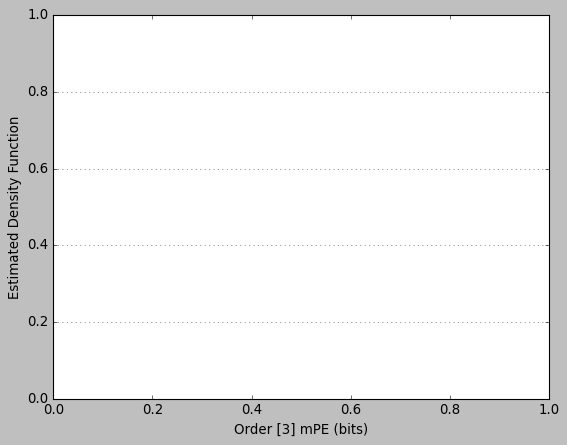

traj_4
TRAJECTORY  5
########################## APPLY PCA ##########################


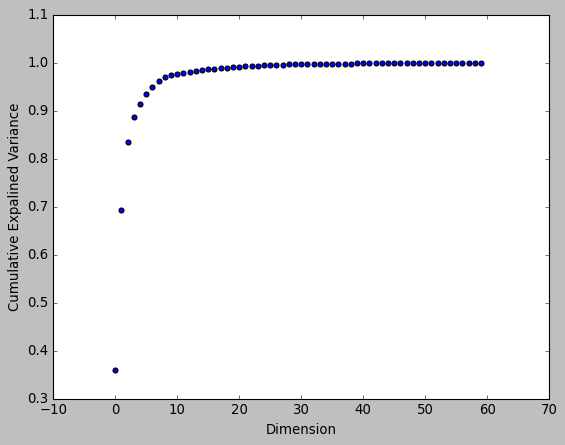

########################## CONTROL ANALYSIS ##########################
15
(2, 15, 1)


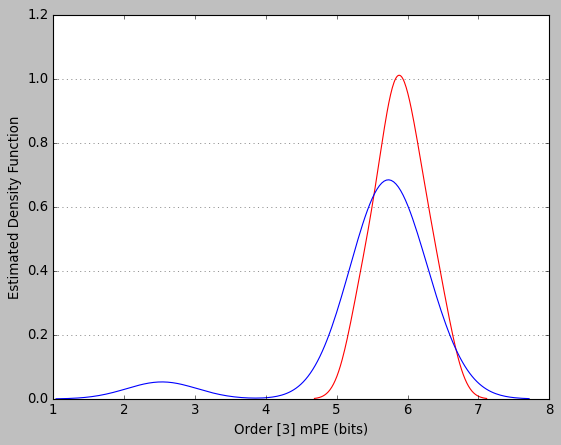

(2, 15, 1)


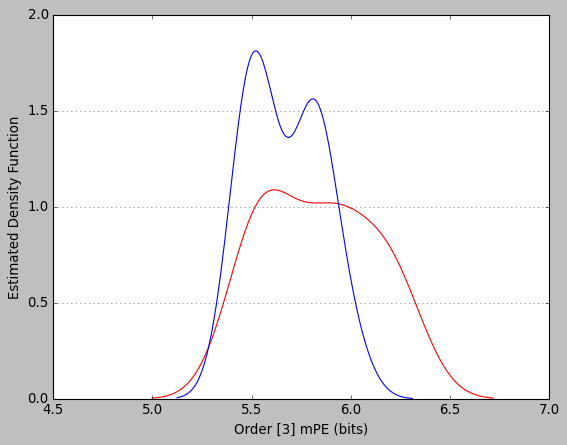

(2, 15, 1)


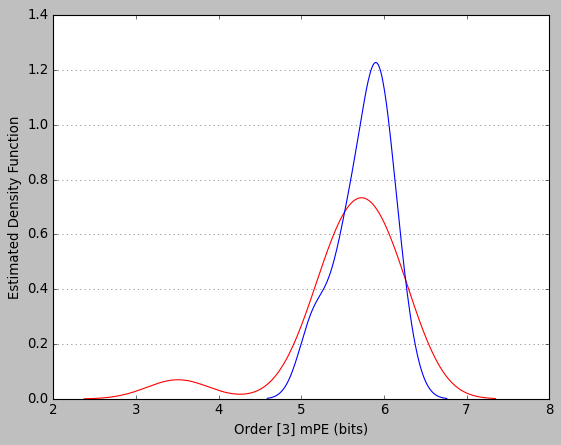

########################## ENTROPY ANALYSIS ##########################
6 15


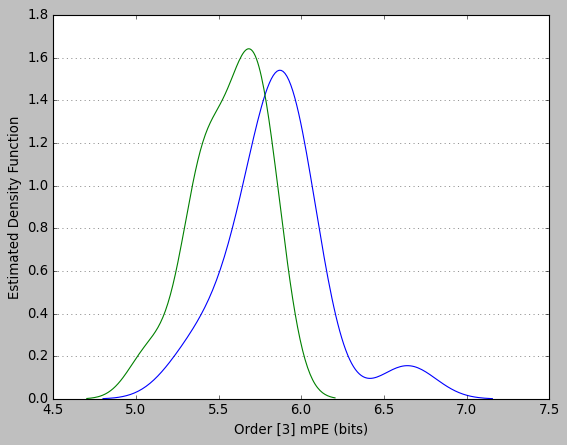

traj_2
TRAJECTORY  6
########################## APPLY PCA ##########################


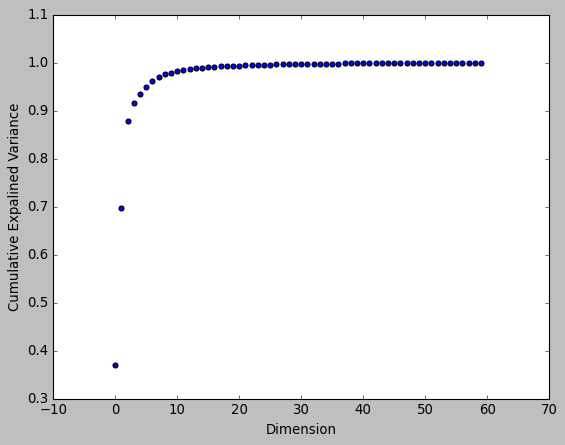

########################## CONTROL ANALYSIS ##########################
15
(2, 15, 1)


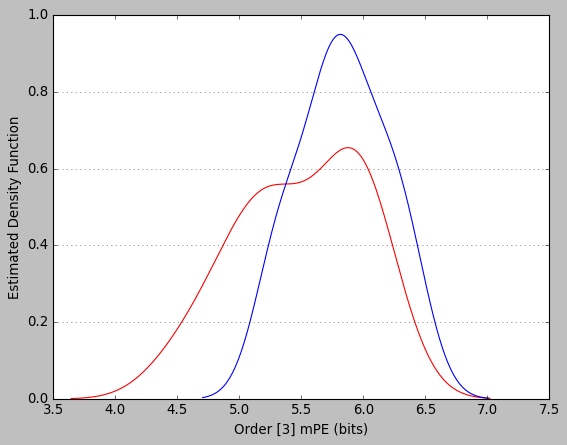

(2, 15, 1)


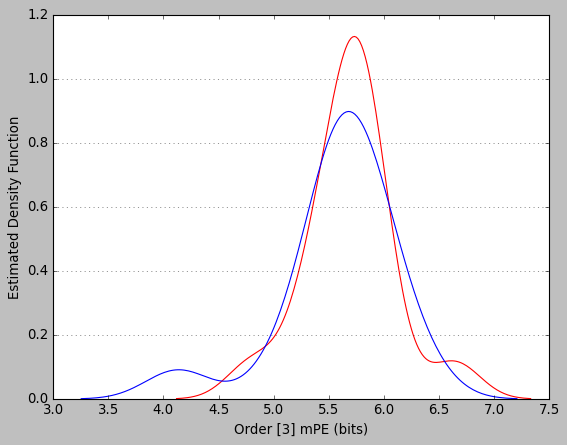

########################## ENTROPY ANALYSIS ##########################
6 15


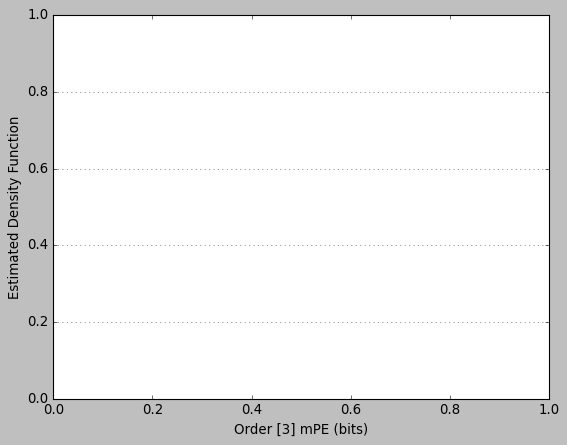

traj_6
TRAJECTORY  7
########################## APPLY PCA ##########################


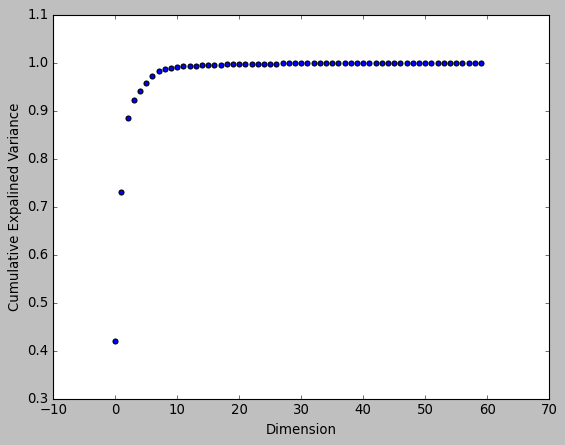

########################## CONTROL ANALYSIS ##########################
15
(2, 15, 1)


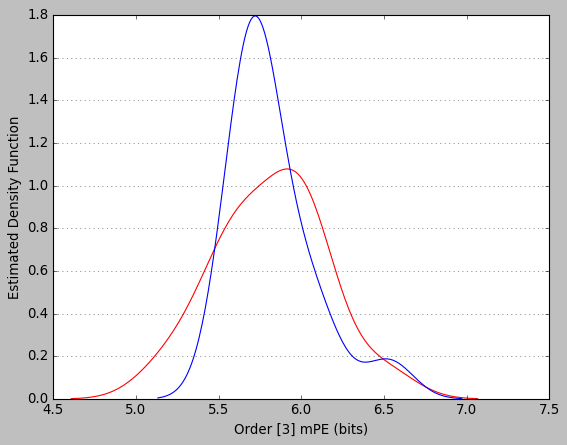

########################## ENTROPY ANALYSIS ##########################
6 15


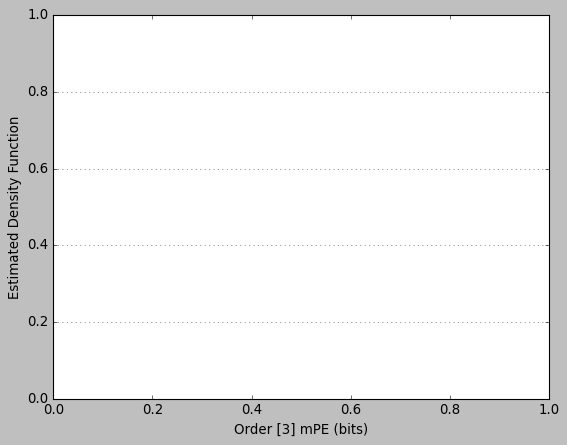

traj_5
TRAJECTORY  8
########################## APPLY PCA ##########################


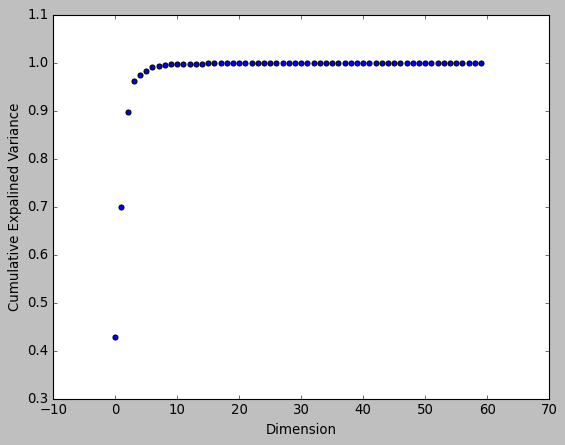

########################## CONTROL ANALYSIS ##########################
15
(2, 15, 1)


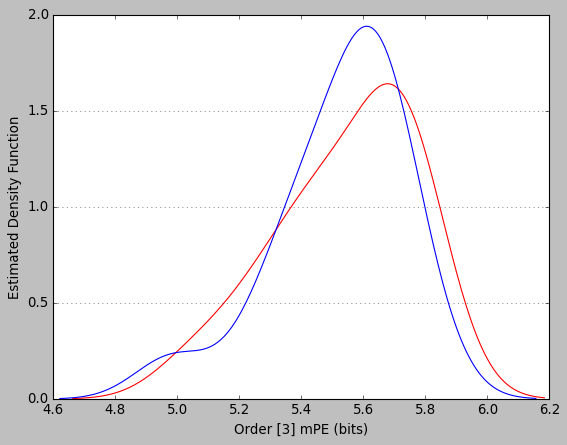

########################## ENTROPY ANALYSIS ##########################
6 15


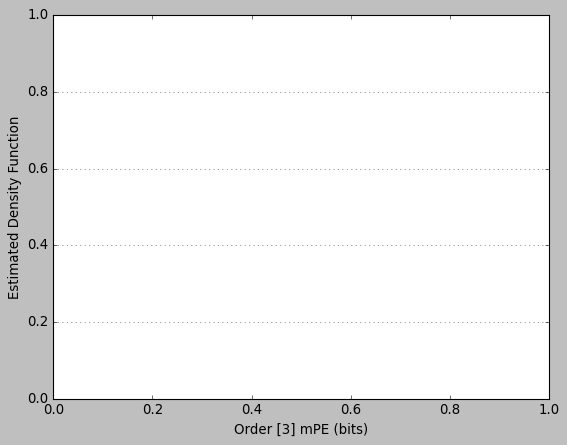

traj_3
TRAJECTORY  9
########################## APPLY PCA ##########################


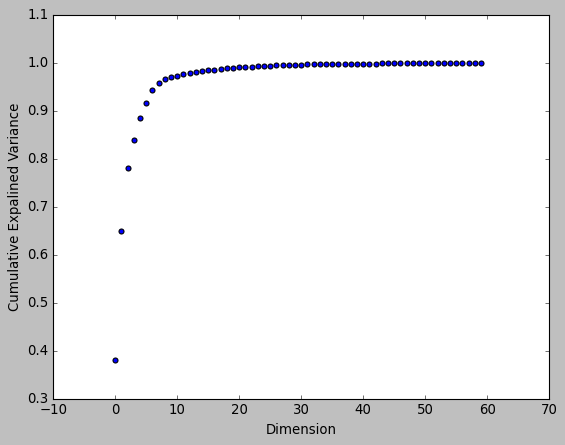

########################## CONTROL ANALYSIS ##########################
15
(2, 15, 1)


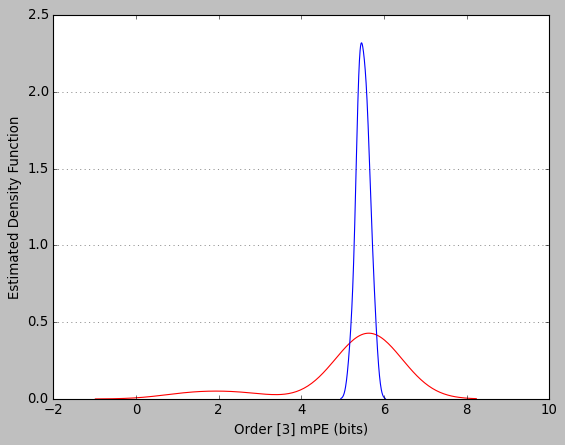

(2, 15, 1)


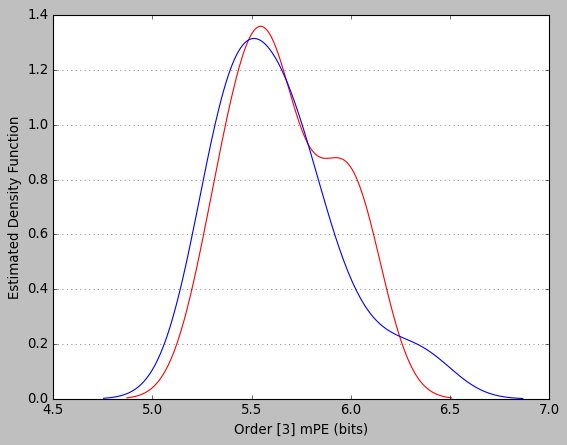

########################## ENTROPY ANALYSIS ##########################
3 15


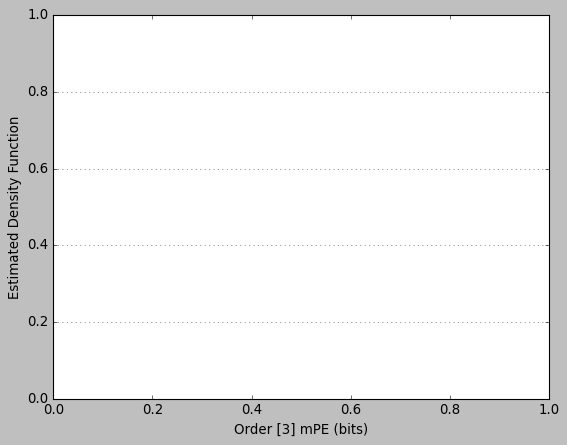

traj_7
TRAJECTORY  10
########################## APPLY PCA ##########################


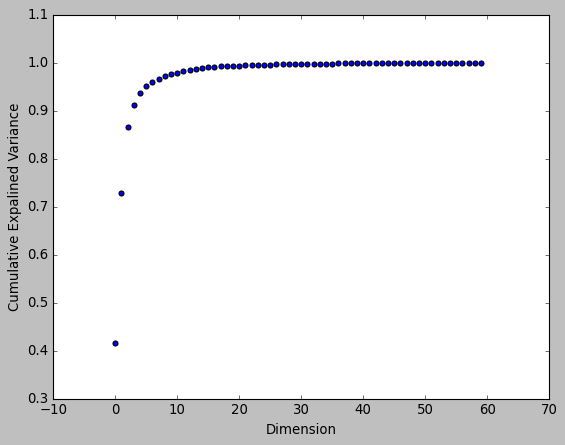

########################## CONTROL ANALYSIS ##########################
15
(2, 15, 1)


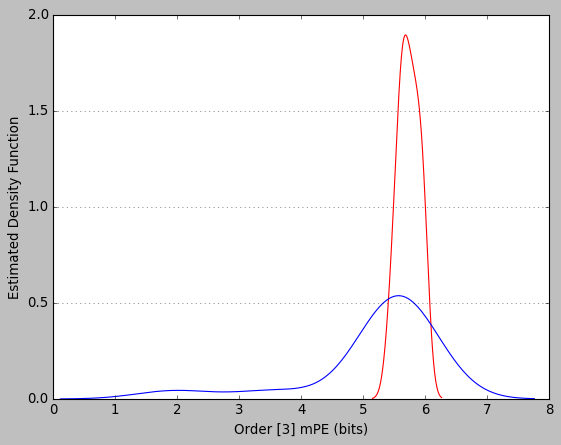

(2, 15, 1)


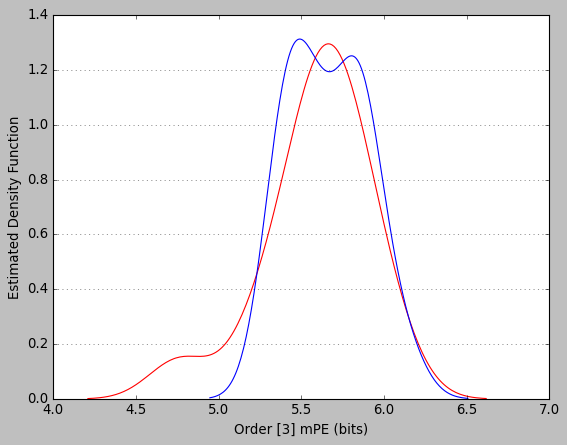

########################## ENTROPY ANALYSIS ##########################
6 15


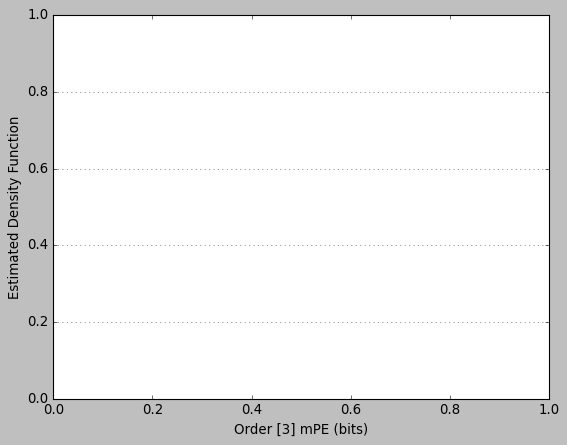

traj_1
TRAJECTORY  11
########################## APPLY PCA ##########################


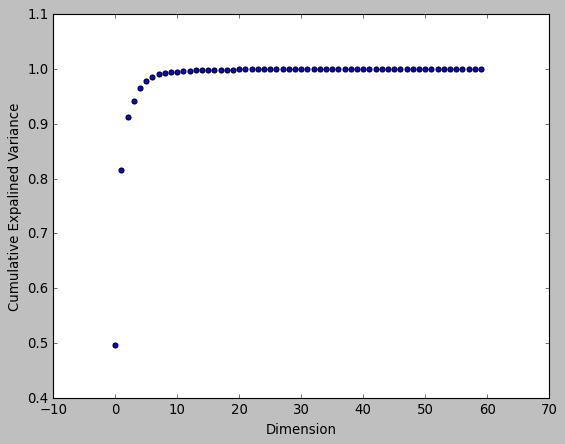

########################## CONTROL ANALYSIS ##########################
15
(2, 15, 1)


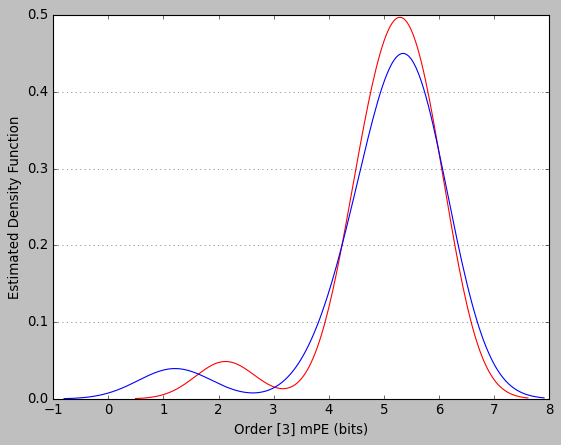

########################## ENTROPY ANALYSIS ##########################
6 15


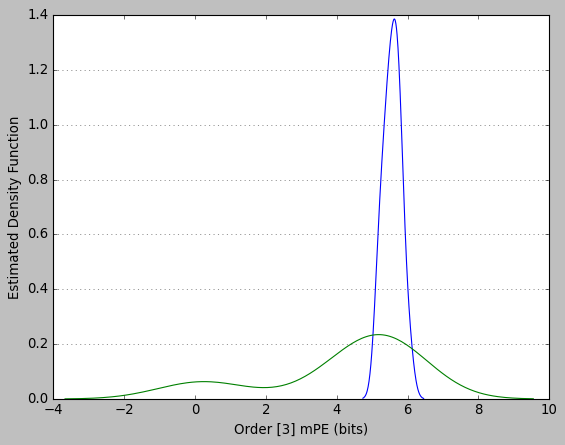

In [6]:
###################################################################################################################################################
####################################################################### PCA #######################################################################
###################################################################################################################################################

# n_PC = 4
significance_level = 0.05
decimals = 3
use_all = False
n_clusters_kmeans = 15
unit_length_entropy = 3500
save = True
use_PCA = True
dims = np.arange(9,12)
nPCs = [2,3,4]

for n_PC in nPCs:
    count = 0
    for which_traj, length in enumerate(lengths):

        if count <= 3:
            mode = 'normal'
        else:
            mode = 'drug'

        name = names[count]
        print(name)

        measures = np.zeros((7, 100))    
        # consists of:
        # - explained variance
        # - p-value (control)
        # - j-s (control)
        # - p-value(result)
        # - j-s (result)
        # - mean mPE
        # - std mPE

        print('TRAJECTORY ', str(which_traj))
        # inspecting inter-dimensional variance with PCA

        if which_traj == 0:
            idx = 0
        else:
            idx += lengths[which_traj-1]

        traj = rats[idx:idx+length, :]
        
        if use_PCA:

            print('########################## APPLY PCA ##########################')

            pca = PCA()
            pca.fit(traj)

            explained_var_plot = [np.sum(pca.explained_variance_ratio_[0:i+1]) for i in range(len(pca.explained_variance_ratio_))]
            measures[0, 0:len(explained_var_plot)] = pca.explained_variance_ratio_

            plt.scatter(np.arange(traj.shape[1]), explained_var_plot)
            plt.ylabel('Cumulative Expalined Variance')
            plt.xlabel('Dimension')

            ##### IMAGES ARE SAVED IN TRAJECTORY FOLDER #####
            path_out = '/rds/general/user/lr4617/home/4th_Year_Project/Final_Report/entropy_analysis/mPE_vs_time/micro/' + str(n_PC) + 'PC/control/' + mode + '/' + name + '/'
            name_out = mode + '_explained_var_' + name
            # plt.savefig(path_out +  name_out  + ".png")
            plt.show()

            # reduce data according to explained variance values using linear PCA
            pca = PCA(n_components=n_PC)
            reduced_traj = pca.fit_transform(traj)

        else:
            reduced_traj = traj[:, dims]



        ###################################################################################################################################################
        ########################################################### CONTROL ANALYSIS ######################################################################
        ###################################################################################################################################################

        print('########################## CONTROL ANALYSIS ##########################')

        unit_length = unit_length_entropy
        minutes = 30
        bin_length = 30*60*minutes
        bins_number = int(reduced_traj.shape[0]/bin_length)
        traj_number = int(bin_length/unit_length)
        print(traj_number)
        orders = [3]
        random = True

        too_low = True
        while too_low == True:

            ########## Calculating mPE ##########
            mPE_vector = get_mPE_matrix_(reduced_traj, bins_number, traj_number, orders, random)

            ########## plotting mPE continuous distribution as a function of time ##########
            fig = plt.figure()
            c = ['r', 'b']

            ax = sns.kdeplot(mPE_vector[0, :, 0], color=c[0])
            ax = sns.kdeplot(mPE_vector[1, :, 0], color=c[1])

            plt.grid(axis='y', alpha=0.75)
            plt.xlabel('Order [3] mPE (bits)')
            plt.ylabel('Estimated Density Function')

            path_out = '/rds/general/user/lr4617/home/4th_Year_Project/Final_Report/entropy_analysis/mPE_vs_time/micro/' + str(n_PC) + 'PC/control/' +  mode + '/' + name + '/'
            name_out = mode + '_control_' + name

            plt.show()

            ########## calculate p-value ##########
            [_, p_value] = stats.ks_2samp(mPE_vector[0, :, 0], mPE_vector[1, :, 0])

            if p_value > 0.4:
                too_low = False
                break

        path_out = '/rds/general/user/lr4617/home/4th_Year_Project/Final_Report/entropy_analysis/mPE_vs_time/micro/' + str(n_PC) + 'PC/control/' + mode + '/' + name + '.npy'
        np.save(path_out, mPE_vector)

        ########## Retrieve maxiumum number of elements based on a raw decimal discretization ##########
        data = mPE_vector.flatten()
        kmeans = KMeans(n_clusters=n_clusters_kmeans).fit(data.reshape(-1,1))
        kmeans.predict(data.reshape(-1,1))
        centroids = kmeans.cluster_centers_
        centroids = [centroids[i] for i in range(len(centroids))]
        centroids = np.asarray(centroids)

        ########## Get probability vectors ##########
        prob1 = probability_v2(mPE_vector[0, :, 0], centroids)
        prob2 = probability_v2(mPE_vector[1, :, 0], centroids)

        ########## Evaluation ##########
        js_distance = distance.jensenshannon(prob1, prob2)

        measures[1, 0] = p_value
        measures[2, 0] = js_distance


        ###################################################################################################################################################
        ########################################################### ENTROPY ANALYSIS ######################################################################
        ###################################################################################################################################################


        print('########################## ENTROPY ANALYSIS ##########################')

        ########## Entropy Calculation ##########
        unit_length = unit_length_entropy
        minutes = 30
        bin_length = 30*60*minutes
        bins_number = int(reduced_traj.shape[0]/bin_length)
        traj_number = int(bin_length/unit_length)
        
        orders = [3]
        
        print(bins_number, traj_number)

        
        ########## Calculate mPE vector ##########
        mPE_vector = get_mPE_matrix_(reduced_traj, bins_number, traj_number, orders, random=False)
        path_out = '/rds/general/user/lr4617/home/4th_Year_Project/Final_Report/entropy_analysis/mPE_vs_time/micro/' + str(n_PC) + 'PC/result/' + mode + '/' + name + '.npy'
        np.save(path_out, mPE_vector)

        ########## Retrieve maxiumum number of elements based on k-means discretization ##########
        data = mPE_vector.flatten()
        kmeans = KMeans(n_clusters=n_clusters_kmeans).fit(data.reshape(-1,1))
        kmeans.predict(data.reshape(-1,1))
        centroids = kmeans.cluster_centers_
        centroids = [centroids[i] for i in range(len(centroids))]
        centroids = np.asarray(centroids)

        ########## plotting mPE continuous distribution as a function of time ##########        
        fig = plt.figure()
        compare_to = mPE_vector[0, :, 0]
        p_value_array = np.zeros((bins_number-1, ))
        js_array = np.zeros((bins_number-1, ))
        means = np.zeros((bins_number, ))
        means[0] = np.mean(compare_to)
        stds = np.zeros((bins_number, ))
        stds[0] = np.std(compare_to)

        for bin_n in range(1, bins_number):
            [_, p_value] = stats.ks_2samp(mPE_vector[bin_n, :, 0], compare_to)
            p_value_array[bin_n -1] = p_value

            prob1 = probability_v2(compare_to, centroids)
            prob2 = probability_v2(mPE_vector[bin_n, :, 0], centroids)

            js_distance = distance.jensenshannon(prob1, prob2)
            js_array[bin_n -1] = js_distance   

            if p_value <= significance_level:
                ax = sns.kdeplot(mPE_vector[bin_n, :, 0])
                compare_to = mPE_vector[bin_n, :, 0]

        plt.grid(axis='y', alpha=0.75)
        plt.xlabel('Order [3] mPE (bits)')
        plt.ylabel('Estimated Density Function')

        path_out = '/rds/general/user/lr4617/home/4th_Year_Project/Final_Report/entropy_analysis/mPE_vs_time/micro/' + str(n_PC) + 'PC/result/' + mode + '/' + name + '/'
        name_out = mode + '_result_' + name

        # plt.savefig(path_out +  name_out  + ".png")    
        plt.show()

        measures[3, 0: p_value_array.shape[0]] = p_value_array
        measures[4, 0: js_array.shape[0]] = js_array

        measures[5, 0:means.shape[0]] = means
        measures[6, 0:stds.shape[0]] = stds

        path_out = '/rds/general/user/lr4617/home/4th_Year_Project/Final_Report/entropy_analysis/mPE_vs_time/micro/' + str(n_PC) + 'PC/' + mode + '/specs_' + name + '.npy'
        # np.save(path_out, measures)

        count +=1